# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


In [2]:
import theano
theano.__version__

'0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291'

All data get stored in a python object InputData. Therefore we can use python serialization to save the input of the models. In the next chapter we will see different ways to create data but for this example we will use a stored one

In [3]:
# geo_data = gp.read_pickle('../input_data/NoFault.pickle')
# geo_data.n_faults = 0
# print(geo_data)

In [4]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

In [5]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('SecondaryReservoir','Seal','Reservoir', 'NonReservoirDeep')},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

In [6]:
geo_data = gp.select_series(geo_data, ['Rest'])
geo_data.set_formation_number(['SecondaryReservoir', 'Seal','Reservoir','NonReservoirDeep'])

In [7]:
interp_data = gp.InterpolatorInput(geo_data, u_grade = [3])

This geo_data object contains essential information that we can access through the correspondent getters. Such a the coordinates of the grid.

In [8]:
print(gp.get_grid(geo_data))

[[    0.             0.         -2000.        ]
 [    0.             0.         -1959.18371582]
 [    0.             0.         -1918.36730957]
 ..., 
 [ 2000.          2000.           -81.63265228]
 [ 2000.          2000.           -40.81632614]
 [ 2000.          2000.             0.        ]]


In [9]:
np.unique(geo_data.series.values)

array(['MainFault', 'NonReservoirDeep', 'Reservoir', 'Seal',
       'SecondaryReservoir'], dtype=object)

The main input the potential field method is the coordinates of interfaces points as well as the orientations. These pandas dataframes can we access by the following methods:

#### Interfaces Dataframe

In [10]:
gp.get_data(geo_data, 'interfaces').head()

,X,Y,Z,formation,series,annotations
5,800.0,200.0,-1400.0,Reservoir,Rest,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
6,800.0,1800.0,-1400.0,Reservoir,Rest,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
7,600.0,1000.0,-1050.0,Reservoir,Rest,"${\bf{x}}_{\alpha \,{\bf{1}},2}$"
8,300.0,1000.0,-950.0,Reservoir,Rest,"${\bf{x}}_{\alpha \,{\bf{1}},3}$"
9,2000.0,1000.0,-1275.0,Reservoir,Rest,"${\bf{x}}_{\alpha \,{\bf{1}},4}$"


#### Foliations Dataframe

In [12]:
gp.get_data(geo_data, 'foliations').head()

,X,Y,Z,dip,azimuth,polarity,formation,series,annotations
1,1450.0,1000.0,-1150.0,18.435,90.0,1,Reservoir,Rest,"${\bf{x}}_{\beta \,{\bf{3}},0}$"


It is important to notice the columns of each data frame. These not only contains the geometrical properties of the data but also the **formation** and **series** at which they belong. This division is fundamental in order to preserve the depositional ages of the setting to model.

A projection of the aforementioned data can be visualized in to 2D by the following function. It is possible to choose the direction of visualization as well as the series:

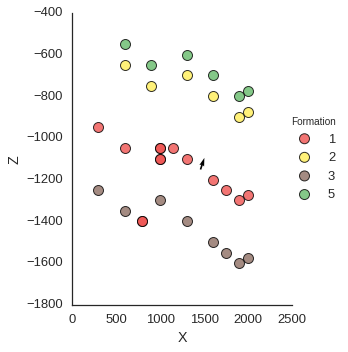

In [8]:
geo_data.geo_data_type= 3
gp.plot_data(geo_data, series='Rest', direction='y')

GemPy supports visualization in 3D as well trough vtk.

In [9]:
#ta_3D(geo_data)

## The ins and outs of Input data objects

As we have seen objects DataManagement.InputData (usually called geo_data in the tutorials) aim to have all the original geological properties, measurements and geological relations stored. 

Once we have the data ready to generate a model, we will need to create the next object type towards the final geological model:

In [16]:
theano.config.warn_float64 = 'warn'

theano.config.floatX

import theano.tensor as T

a = T.scalar(dtype='int32')
b = T.scalar(dtype='float32')
c = a/b
c.eval({a:2, b:3}).dtype

In [6]:
interp_data = gp.InterpolatorInput(geo_data, u_grade = [3])
print(interp_data)

TypeError: Expected an integer

In [11]:
5

5

In [ ]:
interp_data.get_formation_number()


By default (there is a flag in case you do not need) when we create a interp_data object we also compile the theano function that compute the model. That is the reason why takes long.

gempy.DataManagement.InterpolatorInput (usually called interp_data in the tutorials) prepares the original data to the interpolation algorithm by scaling the coordinates for better and adding all the mathematical parametrization needed.


In [17]:
gp.get_kriging_parameters(interp_data)

range 0.8882311582565308 3464.1015172
Number of drift equations [2 2]
Covariance at 0 0.01878463476896286
Foliations nugget effect 0.009999999776482582


 These later parameters have a default value computed from the original data or can be changed by the user (be careful of changing any of these if you do not fully understand their meaning).
 
At this point, we have all what we need to compute our model. By default everytime we compute a model we obtain 3 results:

- Lithology block model
- The potential field
- Faults network block model

In [8]:
%%timeit
sol = gp.compute_model(interp_data)

IndexError: One of the index value is out of bound. Error code: 65535.\n
Apply node that caused the error: GpuAdvancedSubtensor1(for{gpu,scan_fn}.0, Elemwise{add,no_inplace}.0)
Toposort index: 409
Inputs types: [CudaNdarrayType(float32, vector), TensorType(int64, vector)]
Inputs shapes: [(4,), (4,)]
Inputs strides: [(1,), (8,)]
Inputs values: [b'CudaNdarray([ 0.03435151  0.11909181 -0.02655532  0.13297006])', array([0, 1, 2, 4])]
Inputs type_num: ['', 7]
Outputs clients: [[HostFromGpu(GpuAdvancedSubtensor1.0), GpuAdvancedIncSubtensor1{no_inplace,set}(<CudaNdarrayType(float32, vector)>, GpuAdvancedSubtensor1.0, Elemwise{add,no_inplace}.0)]]

Debugprint of the apply node: 
GpuAdvancedSubtensor1 [id A] <CudaNdarrayType(float32, vector)> ''   
 |for{gpu,scan_fn} [id B] <CudaNdarrayType(float32, vector)> ''   
 | |<TensorType(int64, scalar)> [id C] <TensorType(int64, scalar)>
 | |Elemwise{Cast{int32}} [id D] <TensorType(int32, vector)> ''   
 | | |<TensorType(int64, vector)> [id E] <TensorType(int64, vector)>
 | |Elemwise{Cast{int32}} [id F] <TensorType(int32, vector)> ''   
 | | |<TensorType(int64, vector)> [id G] <TensorType(int64, vector)>
 | |GpuFromHost [id H] <CudaNdarrayType(float32, vector)> ''   
 | | |Elemwise{Composite{Cast{float32}((i0 - i1))}} [id I] <TensorType(float32, vector)> ''   
 | |   |<TensorType(int64, vector)> [id G] <TensorType(int64, vector)>
 | |   |<TensorType(int64, vector)> [id E] <TensorType(int64, vector)>
 | |<TensorType(int64, scalar)> [id C] <TensorType(int64, scalar)>
 | |GpuSubtensor{int64:int64:} [id J] <CudaNdarrayType(float32, vector)> ''   
 |   |GpuElemwise{Composite{((((i0 * i1 * i2 * i3) + (-i4)) + i5) + i6)}}[(0, 3)] [id K] <CudaNdarrayType(float32, vector)> ''   
 |   | |CudaNdarrayConstant{[-1.]} [id L] <CudaNdarrayType(float32, (True,))>
 |   | |GpuDimShuffle{x} [id M] <CudaNdarrayType(float32, (True,))> ''   
 |   | | |<CudaNdarrayType(float32, (True, True))> [id N] <CudaNdarrayType(float32, (True, True))>
 |   | |GpuDimShuffle{x} [id O] <CudaNdarrayType(float32, (True,))> ''   
 |   | | |<CudaNdarrayType(float32, (True, True))> [id P] <CudaNdarrayType(float32, (True, True))>
 |   | |GpuCAReduce{add}{1,0} [id Q] <CudaNdarrayType(float32, vector)> ''   
 |   | | |GpuElemwise{Composite{(i0 * i1 * i2 * (((i3 + (i4 / i5)) - ((i6 * i7) / i8)) + ((i9 * i10) / i11)))}}[(0, 0)] [id R] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |GpuFromHost [id S] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |Subtensor{:int64:} [id T] <TensorType(float32, matrix)> ''   
 |   | |   |   |InplaceDimShuffle{1,0} [id U] <TensorType(float32, matrix)> ''   
 |   | |   |   | |Reshape{2} [id V] <TensorType(float32, matrix)> ''   
 |   | |   |   |   |Alloc [id W] <TensorType(float32, (False, True, True, False))> ''   
 |   | |   |   |   | |Reshape{1} [id X] <TensorType(float32, vector)> 'Dual Kriging parameters'   
 |   | |   |   |   | |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id Y] <TensorType(int64, scalar)> ''   
 |   | |   |   |   | | |Shape_i{1} [id Z] <TensorType(int64, scalar)> ''   
 |   | |   |   |   | | | |Nonzero [id BA] <TensorType(int64, matrix)> ''   
 |   | |   |   |   | | |   |HostFromGpu [id BB] <TensorType(float32, vector)> ''   
 |   | |   |   |   | | |     |GpuReshape{1} [id BC] <CudaNdarrayType(float32, vector)> ''   
 |   | |   |   |   | | |       |GpuElemwise{mul,no_inplace} [id BD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |   |   | | |       | |Coordinates of the grid points to interpolate_copy[cuda] [id BE] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   | | |       | |GpuFromHost [id BF] <CudaNdarrayType(float32, col)> ''   
 |   | |   |   |   | | |       |   |Elemwise{Cast{float32}} [id BG] <TensorType(float32, col)> ''   
 |   | |   |   |   | | |       |     |InplaceDimShuffle{0,x} [id BH] <TensorType(bool, col)> ''   
 |   | |   |   |   | | |       |       |Elemwise{eq,no_inplace} [id BI] <TensorType(bool, vector)> 'Yet simulated LITHOLOGY node'   
 |   | |   |   |   | | |       |TensorConstant{(1,) of -1} [id BJ] <TensorType(int64, (True,))>
 |   | |   |   |   | | |TensorConstant{3} [id BK] <TensorType(int64, scalar)>
 |   | |   |   |   | | |Shape_i{0} [id BL] <TensorType(int64, scalar)> ''   
 |   | |   |   |   | | | |Rest of the points of the layers_copy[cuda] [id BM] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   | | |Shape_i{0} [id BN] <TensorType(int64, scalar)> ''   
 |   | |   |   |   | |   |Reference points for every layer_copy[cuda] [id BO] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |   |   |   | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |   |   |   | |Elemwise{add,no_inplace} [id BQ] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id BR] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |Elemwise{mul,no_inplace} [id BS] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | | |TensorConstant{3} [id BK] <TensorType(int64, scalar)>
 |   | |   |   |   |   | | |Elemwise{sub,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id BU] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |   | |Elemwise{lt,no_inplace} [id BV] <TensorType(bool, scalar)> ''   
 |   | |   |   |   |   | |   | | |<TensorType(int64, scalar)> [id BW] <TensorType(int64, scalar)>
 |   | |   |   |   |   | |   | | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |   | |<TensorType(int64, scalar)> [id BW] <TensorType(int64, scalar)>
 |   | |   |   |   |   | |   | |Shape_i{0} [id BY] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |   | | |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   |   | |   | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |   | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id CB] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |     |Elemwise{lt,no_inplace} [id CC] <TensorType(bool, scalar)> ''   
 |   | |   |   |   |   | |     | |<TensorType(int64, scalar)> [id CD] <TensorType(int64, scalar)>
 |   | |   |   |   |   | |     | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |     |<TensorType(int64, scalar)> [id CD] <TensorType(int64, scalar)>
 |   | |   |   |   |   | |     |Shape_i{0} [id BY] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |     |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |     |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id BU] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |TensorConstant{3} [id BK] <TensorType(int64, scalar)>
 |   | |   |   |   |   | |Elemwise{sub,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |Shape_i{1} [id CE] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | | |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   |   | |TensorConstant{-3} [id CF] <TensorType(int64, scalar)>
 |   | |   |   |   |   |Elemwise{sub,no_inplace} [id CG] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id CH] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | | |Elemwise{lt,no_inplace} [id CI] <TensorType(bool, scalar)> ''   
 |   | |   |   |   |   | | | |<TensorType(int64, scalar)> [id CJ] <TensorType(int64, scalar)>
 |   | |   |   |   |   | | | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | | |<TensorType(int64, scalar)> [id CJ] <TensorType(int64, scalar)>
 |   | |   |   |   |   | | |Shape_i{0} [id BL] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   | | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
 |   | |   |   |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id CK] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   |   |Elemwise{lt,no_inplace} [id CL] <TensorType(bool, scalar)> ''   
 |   | |   |   |   |   |   | |<TensorType(int64, scalar)> [id CM] <TensorType(int64, scalar)>
 |   | |   |   |   |   |   | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   |   |<TensorType(int64, scalar)> [id CM] <TensorType(int64, scalar)>
 |   | |   |   |   |   |   |Shape_i{0} [id BL] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   |   |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id CH] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |   |<TensorType(int64, scalar)> [id CN] <TensorType(int64, scalar)>
 |   | |   |   |   |MakeVector{dtype='int64'} [id CO] <TensorType(int64, vector)> ''   
 |   | |   |   |     |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id Y] <TensorType(int64, scalar)> ''   
 |   | |   |   |     |Elemwise{add,no_inplace} [id BQ] <TensorType(int64, scalar)> ''   
 |   | |   |   |ScalarFromTensor [id CP] <int64> ''   
 |   | |   |     |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id BR] <TensorType(int64, scalar)> ''   
 |   | |   |GpuJoin [id CQ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | |GpuElemwise{sub,no_inplace} [id CR] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDimShuffle{0,x} [id CS] <CudaNdarrayType(float32, col)> ''   
 |   | |   | | | |GpuSubtensor{int64:int64:int8, int64} [id CT] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   | | |   |ScalarFromTensor [id CU] <int64> ''   
 |   | |   | | |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id CV] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |   |Elemwise{le,no_inplace} [id CW] <TensorType(bool, scalar)> ''   
 |   | |   | | |   |   | |Elemwise{sub,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |   | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | | |   |   |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id CB] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id BU] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |ScalarFromTensor [id CX] <int64> ''   
 |   | |   | | |   | |Elemwise{Switch}[(0, 2)] [id CY] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |   |Elemwise{le,no_inplace} [id CW] <TensorType(bool, scalar)> ''   
 |   | |   | | |   |   |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id BU] <TensorType(int64, scalar)> ''   
 |   | |   | | |   |Constant{1} [id CZ] <int8>
 |   | |   | | |   |Constant{0} [id DA] <int64>
 |   | |   | | |GpuDimShuffle{x,0} [id DB] <CudaNdarrayType(float32, row)> ''   
 |   | |   | |   |GpuSubtensor{::, int64} [id DC] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | |     |GpuJoin [id DD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |     | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | |     | |GpuJoin [id DE] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |     | | |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   | |     | | |GpuReshape{2} [id DF] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |     | | | |GpuAdvancedSubtensor1 [id DG] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | |     | | | | |GpuReshape{1} [id BC] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | |     | | | | |Subtensor{int64} [id DH] <TensorType(int64, vector)> ''   
 |   | |   | |     | | | |   |Nonzero [id BA] <TensorType(int64, matrix)> ''   
 |   | |   | |     | | | |   |Constant{0} [id DA] <int64>
 |   | |   | |     | | | |TensorConstant{[-1  3]} [id DI] <TensorType(int64, vector)>
 |   | |   | |     | | |Rest of the points of the layers_copy[cuda] [id BM] <CudaNdarrayType(float32, matrix)>
 |   | |   | |     | |Reference points for every layer_copy[cuda] [id BO] <CudaNdarrayType(float32, matrix)>
 |   | |   | |     |Constant{0} [id DA] <int64>
 |   | |   | |GpuElemwise{sub,no_inplace} [id DJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDimShuffle{0,x} [id DK] <CudaNdarrayType(float32, col)> ''   
 |   | |   | | | |GpuSubtensor{int64:int64:int8, int64} [id DL] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   | | |   |ScalarFromTensor [id CU] <int64> ''   
 |   | |   | | |   |ScalarFromTensor [id CX] <int64> ''   
 |   | |   | | |   |Constant{1} [id CZ] <int8>
 |   | |   | | |   |Constant{1} [id DM] <int64>
 |   | |   | | |GpuDimShuffle{x,0} [id DN] <CudaNdarrayType(float32, row)> ''   
 |   | |   | |   |GpuSubtensor{::, int64} [id DO] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | |     |GpuJoin [id DD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |     |Constant{1} [id DM] <int64>
 |   | |   | |GpuElemwise{sub,no_inplace} [id DP] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |   |GpuDimShuffle{0,x} [id DQ] <CudaNdarrayType(float32, col)> ''   
 |   | |   |   | |GpuSubtensor{int64:int64:int8, int64} [id DR] <CudaNdarrayType(float32, vector)> ''   
 |   | |   |   |   |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   |   |   |ScalarFromTensor [id CU] <int64> ''   
 |   | |   |   |   |ScalarFromTensor [id CX] <int64> ''   
 |   | |   |   |   |Constant{1} [id CZ] <int8>
 |   | |   |   |   |Constant{2} [id DS] <int64>
 |   | |   |   |GpuDimShuffle{x,0} [id DT] <CudaNdarrayType(float32, row)> ''   
 |   | |   |     |GpuSubtensor{::, int64} [id DU] <CudaNdarrayType(float32, vector)> ''   
 |   | |   |       |GpuJoin [id DD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |       |Constant{2} [id DS] <int64>
 |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id DV] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id DW] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDimShuffle{0,x} [id DX] <CudaNdarrayType(float32, col)> ''   
 |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id DY] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |GpuReshape{2} [id DZ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |     |GpuAlloc [id EA] <CudaNdarrayType(float32, (False, True, False, False))> ''   
 |   | |   | | |     | |GpuSubtensor{int64:int64:} [id EB] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |     | | |Position of the dips_copy[cuda] [id BZ] <CudaNdarrayType(float32, matrix)>
 |   | |   | | |     | | |ScalarFromTensor [id EC] <int64> ''   
 |   | |   | | |     | | | |<TensorType(int64, scalar)> [id CD] <TensorType(int64, scalar)>
 |   | |   | | |     | | |ScalarFromTensor [id ED] <int64> ''   
 |   | |   | | |     | |   |<TensorType(int64, scalar)> [id BW] <TensorType(int64, scalar)>
 |   | |   | | |     | |TensorConstant{3} [id EE] <TensorType(int8, scalar)>
 |   | |   | | |     | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |   | | |     | |Elemwise{sub,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
 |   | |   | | |     | |Shape_i{1} [id CE] <TensorType(int64, scalar)> ''   
 |   | |   | | |     |MakeVector{dtype='int64'} [id EF] <TensorType(int64, vector)> ''   
 |   | |   | | |       |Elemwise{mul,no_inplace} [id BS] <TensorType(int64, scalar)> ''   
 |   | |   | | |       |Shape_i{1} [id CE] <TensorType(int64, scalar)> ''   
 |   | |   | | |GpuDimShuffle{x,0} [id EG] <CudaNdarrayType(float32, row)> ''   
 |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id EH] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |GpuJoin [id DD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDot22Scalar [id EI] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuReshape{2} [id DZ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuDimShuffle{1,0} [id EJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | | |GpuJoin [id DD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |TensorConstant{2.0} [id EK] <TensorType(float32, scalar)>
 |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id EL] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |<CudaNdarrayType(float32, (True, True))> [id EM] <CudaNdarrayType(float32, (True, True))>
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id EN] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{mul,no_inplace} [id EO] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 26.25]]} [id EP] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id DW] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id EQ] <CudaNdarrayType(float32, (True, True))>
 |   | |   |CudaNdarrayConstant{[[ 17.5]]} [id ER] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{pow,no_inplace} [id ES] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id DW] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id ET] <CudaNdarrayType(float32, (True, True))>
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id EU] <CudaNdarrayType(float32, (True, True))>
 |   | |   |CudaNdarrayConstant{[[ 5.25]]} [id EV] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Pow}[(0, 0)] [id EW] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id DW] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 5.]]} [id EX] <CudaNdarrayType(float32, (True, True))>
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id EY] <CudaNdarrayType(float32, (True, True))>
 |   | |GpuCAReduce{add}{1,0} [id EZ] <CudaNdarrayType(float32, vector)> ''   
 |   | | |GpuElemwise{Composite{(i0 * (i1 * ((i2 * ((i3 + i4 + i5) - (i6 + i7))) - (i8 * ((i3 + i9 + i10) - i11)))))}}[(0, 2)] [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |GpuSubtensor{int64:int64:} [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuDimShuffle{1,0} [id FC] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuReshape{2} [id FD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |   |GpuFromHost [id FE] <CudaNdarrayType(float32, (False, True, True, False))> ''   
 |   | |   | |   | |Alloc [id W] <TensorType(float32, (False, True, True, False))> ''   
 |   | |   | |   |MakeVector{dtype='int64'} [id CO] <TensorType(int64, vector)> ''   
 |   | |   | |ScalarFromTensor [id CP] <int64> ''   
 |   | |   | |ScalarFromTensor [id FF] <int64> ''   
 |   | |   |   |Elemwise{add,no_inplace} [id FG] <TensorType(int64, scalar)> ''   
 |   | |   |     |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id BR] <TensorType(int64, scalar)> ''   
 |   | |   |     |Elemwise{sub,no_inplace} [id CG] <TensorType(int64, scalar)> ''   
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id FH] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id FI] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id FJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDimShuffle{0,x} [id FK] <CudaNdarrayType(float32, col)> ''   
 |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id FL] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |GpuSubtensor{int64:int64:} [id FM] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |     |Rest of the points of the layers_copy[cuda] [id BM] <CudaNdarrayType(float32, matrix)>
 |   | |   | | |     |ScalarFromTensor [id FN] <int64> ''   
 |   | |   | | |     | |<TensorType(int64, scalar)> [id CM] <TensorType(int64, scalar)>
 |   | |   | | |     |ScalarFromTensor [id FO] <int64> ''   
 |   | |   | | |       |<TensorType(int64, scalar)> [id CJ] <TensorType(int64, scalar)>
 |   | |   | | |GpuDimShuffle{x,0} [id EG] <CudaNdarrayType(float32, row)> ''   
 |   | |   | | |GpuDot22Scalar [id FP] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuSubtensor{int64:int64:} [id FM] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuDimShuffle{1,0} [id EJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |TensorConstant{2.0} [id EK] <TensorType(float32, scalar)>
 |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id EL] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |<CudaNdarrayType(float32, (True, True))> [id EM] <CudaNdarrayType(float32, (True, True))>
 |   | |   |CudaNdarrayConstant{[[ 1.]]} [id FQ] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id FR] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 8.75]]} [id FS] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id FT] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id FJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |<CudaNdarrayType(float32, (True, True))> [id EM] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id ET] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id FU] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 0.75]]} [id FV] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id FT] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id FW] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{(i0 * sqr(i1))},no_inplace} [id FX] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id FW] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id FT] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))}}[(0, 1)] [id FY] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 3.5]]} [id FZ] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id FT] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 5.]]} [id EX] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id GA] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id GB] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuDimShuffle{0,x} [id GC] <CudaNdarrayType(float32, col)> ''   
 |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id GD] <CudaNdarrayType(float32, vector)> ''   
 |   | |   | | |   |GpuSubtensor{int64:int64:} [id GE] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |     |Reference points for every layer_copy[cuda] [id BO] <CudaNdarrayType(float32, matrix)>
 |   | |   | | |     |ScalarFromTensor [id FN] <int64> ''   
 |   | |   | | |     |ScalarFromTensor [id FO] <int64> ''   
 |   | |   | | |GpuDimShuffle{x,0} [id EG] <CudaNdarrayType(float32, row)> ''   
 |   | |   | | |GpuDot22Scalar [id GF] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuSubtensor{int64:int64:} [id GE] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |GpuDimShuffle{1,0} [id EJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | | |TensorConstant{2.0} [id EK] <TensorType(float32, scalar)>
 |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id EL] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |<CudaNdarrayType(float32, (True, True))> [id EM] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id GG] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 8.75]]} [id FS] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id GH] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id GB] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | | |<CudaNdarrayType(float32, (True, True))> [id EM] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id ET] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id GI] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 0.75]]} [id FV] <CudaNdarrayType(float32, (True, True))>
 |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id GH] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id FW] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuElemwise{Composite{((i0 * sqr(i1)) + (i2 * (i1 ** i3)))}}[(0, 1)] [id GJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     |CudaNdarrayConstant{[[ 7.]]} [id FW] <CudaNdarrayType(float32, (True, True))>
 |   | |     |GpuElemwise{TrueDiv}[(0, 0)] [id GH] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     |CudaNdarrayConstant{[[ 3.5]]} [id FZ] <CudaNdarrayType(float32, (True, True))>
 |   | |     |CudaNdarrayConstant{[[ 5.]]} [id EX] <CudaNdarrayType(float32, (True, True))>
 |   | |GpuCAReduce{add}{1,0} [id GK] <CudaNdarrayType(float32, vector)> ''   
 |   | | |GpuElemwise{Composite{(((i0 * i1) * i2) * i3)}}[(0, 2)] [id GL] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |GpuSubtensor{int64:int64:} [id GM] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuDimShuffle{1,0} [id FC] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |ScalarFromTensor [id FF] <int64> ''   
 |   | |   | |ScalarFromTensor [id GN] <int64> ''   
 |   | |   |   |Elemwise{Add}[(0, 0)] [id GO] <TensorType(int64, scalar)> ''   
 |   | |   |     |Elemwise{add,no_inplace} [id FG] <TensorType(int64, scalar)> ''   
 |   | |   |     |<TensorType(int64, scalar)> [id CN] <TensorType(int64, scalar)>
 |   | |   |<CudaNdarrayType(float32, (True, True))> [id N] <CudaNdarrayType(float32, (True, True))>
 |   | |   |GpuDimShuffle{1,0} [id GP] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   | |GpuReshape{2} [id GQ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |   |   |GpuAlloc [id GR] <CudaNdarrayType(float32, (False, True, True, False))> ''   
 |   | |   |   | |GpuSubtensor{:int64:} [id GS] <CudaNdarrayType(float32, vector)> ''   
 |   | |   |   | | |<CudaNdarrayType(float32, vector)> [id GT] <CudaNdarrayType(float32, vector)>
 |   | |   |   | | |ScalarFromTensor [id GU] <int64> ''   
 |   | |   |   | |   |<TensorType(int64, scalar)> [id CN] <TensorType(int64, scalar)>
 |   | |   |   | |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id Y] <TensorType(int64, scalar)> ''   
 |   | |   |   | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |   |   | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |   |   | |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + i2), i1), i1, (i0 + i2)), Switch(LT(i0, i2), i0, i2))}}[(0, 2)] [id GV] <TensorType(int64, scalar)> ''   
 |   | |   |   |   |<TensorType(int64, scalar)> [id CN] <TensorType(int64, scalar)>
 |   | |   |   |   |TensorConstant{0} [id BX] <TensorType(int8, scalar)>
 |   | |   |   |   |Shape_i{0} [id GW] <TensorType(int64, scalar)> ''   
 |   | |   |   |     |<CudaNdarrayType(float32, vector)> [id GT] <CudaNdarrayType(float32, vector)>
 |   | |   |   |MakeVector{dtype='int64'} [id GX] <TensorType(int64, vector)> ''   
 |   | |   |     |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id Y] <TensorType(int64, scalar)> ''   
 |   | |   |     |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + i2), i1), i1, (i0 + i2)), Switch(LT(i0, i2), i0, i2))}}[(0, 2)] [id GV] <TensorType(int64, scalar)> ''   
 |   | |   |GpuSubtensor{:int64:} [id GY] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     |GpuJoin [id GZ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     | |TensorConstant{1} [id BP] <TensorType(int8, scalar)>
 |   | |     | |GpuReshape{2} [id HA] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     | | |GpuAdvancedSubtensor1 [id HB] <CudaNdarrayType(float32, vector)> ''   
 |   | |     | | | |GpuReshape{1} [id HC] <CudaNdarrayType(float32, vector)> ''   
 |   | |     | | | | |GpuElemwise{mul,no_inplace} [id HD] <CudaNdarrayType(float32, matrix)> ''   
 |   | |     | | | | | |<CudaNdarrayType(float32, matrix)> [id HE] <CudaNdarrayType(float32, matrix)>
 |   | |     | | | | | |GpuFromHost [id HF] <CudaNdarrayType(float32, row)> ''   
 |   | |     | | | | |   |Elemwise{Cast{float32}} [id HG] <TensorType(float32, row)> ''   
 |   | |     | | | | |     |InplaceDimShuffle{x,0} [id HH] <TensorType(bool, row)> ''   
 |   | |     | | | | |       |Elemwise{eq,no_inplace} [id BI] <TensorType(bool, vector)> 'Yet simulated LITHOLOGY node'   
 |   | |     | | | | |TensorConstant{(1,) of -1} [id BJ] <TensorType(int64, (True,))>
 |   | |     | | | |Subtensor{int64} [id HI] <TensorType(int64, vector)> ''   
 |   | |     | | |   |Nonzero [id HJ] <TensorType(int64, matrix)> ''   
 |   | |     | | |   | |HostFromGpu [id HK] <TensorType(float32, vector)> ''   
 |   | |     | | |   |   |GpuReshape{1} [id HC] <CudaNdarrayType(float32, vector)> ''   
 |   | |     | | |   |Constant{0} [id DA] <int64>
 |   | |     | | |TensorConstant{[ 9 -1]} [id HL] <TensorType(int64, vector)>
 |   | |     | |<CudaNdarrayType(float32, matrix)> [id HM] <CudaNdarrayType(float32, matrix)>
 |   | |     |ScalarFromTensor [id GU] <int64> ''   
 |   | |GpuCAReduce{add}{1,0} [id HN] <CudaNdarrayType(float32, vector)> ''   
 |   |   |GpuElemwise{Mul}[(0, 0)] [id HO] <CudaNdarrayType(float32, matrix)> ''   
 |   |     |GpuSubtensor{int64::} [id HP] <CudaNdarrayType(float32, matrix)> ''   
 |   |     | |GpuDimShuffle{1,0} [id FC] <CudaNdarrayType(float32, matrix)> ''   
 |   |     | |ScalarFromTensor [id GN] <int64> ''   
 |   |     |GpuSubtensor{::, :int64:} [id HQ] <CudaNdarrayType(float32, matrix)> ''   
 |   |       |<CudaNdarrayType(float32, matrix)> [id HR] <CudaNdarrayType(float32, matrix)>
 |   |       |ScalarFromTensor [id HS] <int64> ''   
 |   |         |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id Y] <TensorType(int64, scalar)> ''   
 |   |<int64> [id HT] <int64>
 |   |<int64> [id HU] <int64>
 |Elemwise{add,no_inplace} [id HV] <TensorType(int64, vector)> ''   
   |TensorConstant{(1,) of -1} [id BJ] <TensorType(int64, (True,))>
   |Subtensor{int64:int64:} [id HW] <TensorType(int64, vector)> ''   
     |Value of the formation_copy [id HX] <TensorType(int64, vector)>
     |ScalarFromTensor [id HY] <int64> ''   
     | |<TensorType(int64, scalar)> [id HZ] <TensorType(int64, scalar)>
     |ScalarFromTensor [id IA] <int64> ''   
       |<TensorType(int64, scalar)> [id IB] <TensorType(int64, scalar)>

Inner graphs of the scan ops:

for{gpu,scan_fn} [id B] <CudaNdarrayType(float32, vector)> ''   
 >GpuElemwise{true_div,no_inplace} [id IC] <CudaNdarrayType(float32, scalar)> ''   
 > |GpuCAReduce{add}{1} [id ID] <CudaNdarrayType(float32, scalar)> ''   
 > | |GpuSubtensor{int32:int32:} [id IE] <CudaNdarrayType(float32, vector)> ''   
 > |   |<CudaNdarrayType(float32, vector)> [id IF] <CudaNdarrayType(float32, vector)> -> [id J]
 > |   |ScalarFromTensor [id IG] <int32> ''   
 > |   | |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id D]
 > |   |ScalarFromTensor [id II] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id IJ] <TensorType(int32, scalar)> -> [id F]
 > |<CudaNdarrayType(float32, scalar)> [id IK] <CudaNdarrayType(float32, scalar)> -> [id H]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: forall_inplace,gpu,scan_fn}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, Coordinates of the grid points to interpolate, <CudaNdarrayType(float32, matrix)>, Value of the formation, <CudaNdarrayType(float32, vector)>, GpuFromHost.0, GpuFromHost.0, GpuFromHost.0, GpuFromHost.0, GpuFromHost.0, GpuFromHost.0, GpuDimShuffle{x}.0, GpuDimShuffle{x,x}.0, GpuDimShuffle{x,x}.0, GpuDimShuffle{x,x}.0, GpuElemwise{sqr,no_inplace}.0, GpuElemwise{mul,no_inplace}.0, GpuElemwise{pow,no_inplace}.0, GpuElemwise{pow,no_inplace}.0, GpuElemwise{pow,no_inplace}.0, GpuElemwise{mul,no_inplace}.0, GpuElemwise{neg,no_inplace}.0, GpuElemwise{true_div,no_inplace}.0, GpuElemwise{mul,no_inplace}.0, GpuElemwise{Mul}[(0, 1)].0, GpuElemwise{mul,no_inplace}.0, GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace}.0, ScalarFromTensor.0, ScalarFromTensor.0, GpuElemwise{Composite{(((i0 * i1) / sqr(i2)) + i3)},no_inplace}.0, GpuAlloc{memset_0=True}.0, Elemwise{minimum,no_inplace}.0, GpuDimShuffle{1,0}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0)
Toposort index: 200
Inputs types: [TensorType(int64, scalar), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector), CudaNdarrayType(float32, 3D), TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(int64, vector), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, vector), CudaNdarrayType(float32, (True,)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True,)), CudaNdarrayType(float32, (True,)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), CudaNdarrayType(float32, (True, True)), Scalar(int64), Scalar(int64), CudaNdarrayType(float32, scalar), CudaNdarrayType(float32, matrix), TensorType(int64, scalar), CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (2, 3, 125000), (), (125000, 3), (9, 125000), (4,), (4,), (1, 3), (30, 3), (30, 3), (1,), (1,), (1,), (1,), (1, 1), (1, 1), (1, 1), (1,), (1,), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (), (), (), (0, 125060), (), (9, 60), (9,), (4,), (4,)]
Inputs strides: [(), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (375000, 125000, 1), (), (3, 1), (125000, 1), (8,), (1,), (0, 1), (3, 1), (3, 1), (0,), (0,), (0,), (0,), (0, 0), (0, 0), (0, 0), (0,), (0,), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (), (), (), (125060, 1), (), (1, 9), (1,), (8,), (8,)]
Inputs values: [array(1), array([125030]), array([125000]), array([125060]), array([125030]), array([0]), array([30]), array([0]), array([1]), array([0]), array([4]), array([3]), 'not shown', array(1), 'not shown', 'not shown', array([1, 2, 3, 5]), b'CudaNdarray([ 0.  0.  0.  0.])', b'CudaNdarray([[ 0.57702309  0.50010002  0.48086923]])', 'not shown', 'not shown', b'CudaNdarray([ 18.43499947])', b'CudaNdarray([ 90.])', b'CudaNdarray([ 1.])', b'CudaNdarray([ 2.])', b'CudaNdarray([[ 2.]])', b'CudaNdarray([[ 0.88823116]])', b'CudaNdarray([[ 0.01878463]])', b'CudaNdarray([ 4.])', b'CudaNdarray([ 4.])', b'CudaNdarray([[ 0.43619636]])', b'CudaNdarray([[ 0.70077407]])', b'CudaNdarray([[ 0.55287892]])', b'CudaNdarray([[ 0.07513854]])', b'CudaNdarray([[-0.01878463]])', b'CudaNdarray([[-17.74500084]])', b'CudaNdarray([[ 0.87239271]])', b'CudaNdarray([[ 15.77909279]])', b'CudaNdarray([[ 2.21151567]])', b'CudaNdarray([[ 9.33673954]])', -30, -60, b'CudaNdarray(0.34333333373069763)', b'CudaNdarray([])', array(4), 'not shown', 'not shown', array([13, 18, 25, 30]), array([ 0, 13, 18, 25])]
Inputs type_num: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, '', 7, '', '', 7, '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 7, 7, '', '', 7, '', '', 7, 7]
Outputs clients: [[GpuSubtensor{int64:int64:int8}(forall_inplace,gpu,scan_fn}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{1})], [HostFromGpu(forall_inplace,gpu,scan_fn}.1)]]

Debugprint of the apply node: 
forall_inplace,gpu,scan_fn}.0 [id A] <CudaNdarrayType(float32, 3D)> ''   
 |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id C] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{-1} [id D] <TensorType(int64, scalar)>
 | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 | | | |Length of interfaces in every series [id F] <TensorType(int64, vector)>
 | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |Elemwise{sub,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id I] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | |   |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id K] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{-1} [id D] <TensorType(int64, scalar)>
 | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | | | |Length of foliations in every series [id M] <TensorType(int64, vector)>
 | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |Elemwise{sub,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id O] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | |   |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id P] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{-1} [id D] <TensorType(int64, scalar)>
 | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | | | |List with the number of formations [id R] <TensorType(int64, vector)>
 | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |Elemwise{sub,no_inplace} [id S] <TensorType(int64, scalar)> ''   
 | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id T] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | |   |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 |   |Grade of the universal drift [id V] <TensorType(int64, vector)>
 |Elemwise{add,no_inplace} [id W] <TensorType(int64, vector)> ''   
 | |Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)] [id X] <TensorType(int64, (True,))> ''   
 | | |InplaceDimShuffle{x} [id Y] <TensorType(int64, (True,))> ''   
 | | | |Elemwise{Composite{(i0 + (i1 * i2))}}[(0, 0)] [id Z] <TensorType(int64, scalar)> ''   
 | | |   |Shape_i{0} [id BA] <TensorType(int64, scalar)> ''   
 | | |   | |Coordinates of the grid points to interpolate [id BB] <CudaNdarrayType(float32, matrix)>
 | | |   |TensorConstant{2} [id BC] <TensorType(int64, scalar)>
 | | |   |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
 | | |     |Rest of the points of the layers [id BE] <TensorType(float32, matrix)>
 | | |TensorConstant{(1,) of 2} [id BF] <TensorType(int64, (True,))>
 | | |InplaceDimShuffle{x} [id BG] <TensorType(int64, (True,))> ''   
 | |   |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64:int64:int64} [id BH] <TensorType(int64, vector)> ''   
 |   |Length of interfaces in every series [id F] <TensorType(int64, vector)>
 |   |ScalarFromTensor [id BI] <int64> ''   
 |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id BJ] <TensorType(int64, scalar)> ''   
 |   |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id BK] <TensorType(bool, scalar)> ''   
 |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id BL] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{le,no_inplace} [id BM] <TensorType(bool, scalar)> ''   
 |   |   | | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id BN] <TensorType(int64, scalar)> ''   
 |   |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 |   |   | | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 |   |   | | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 |   |   | | | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |   | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id I] <TensorType(int64, scalar)> ''   
 |   |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | | | |Elemwise{sub,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 |   |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id I] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id BN] <TensorType(int64, scalar)> ''   
 |   |   | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id BQ] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{le,no_inplace} [id BM] <TensorType(bool, scalar)> ''   
 |   |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id I] <TensorType(int64, scalar)> ''   
 |   |   | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id BL] <TensorType(int64, scalar)> ''   
 |   |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id BQ] <TensorType(int64, scalar)> ''   
 |   |   |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |ScalarFromTensor [id BR] <int64> ''   
 |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id BS] <TensorType(int64, scalar)> ''   
 |   |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id BK] <TensorType(bool, scalar)> ''   
 |   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id BL] <TensorType(int64, scalar)> ''   
 |   |   |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |Constant{1} [id BT] <int64>
 |Elemwise{add,no_inplace} [id BU] <TensorType(int64, vector)> ''   
 | |Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)] [id X] <TensorType(int64, (True,))> ''   
 | |Subtensor{int64:int64:int64} [id BV] <TensorType(int64, vector)> ''   
 |   |Length of interfaces in every series [id F] <TensorType(int64, vector)>
 |   |ScalarFromTensor [id BW] <int64> ''   
 |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id BX] <TensorType(int64, scalar)> ''   
 |   |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id BY] <TensorType(bool, scalar)> ''   
 |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id BZ] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{le,no_inplace} [id CA] <TensorType(bool, scalar)> ''   
 |   |   | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id CB] <TensorType(int64, scalar)> ''   
 |   |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 |   |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 |   |   | | | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id C] <TensorType(int64, scalar)> ''   
 |   |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id CB] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id C] <TensorType(int64, scalar)> ''   
 |   |   | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id CC] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{le,no_inplace} [id CA] <TensorType(bool, scalar)> ''   
 |   |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | |TensorConstant{0} [id CD] <TensorType(int64, scalar)>
 |   |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id C] <TensorType(int64, scalar)> ''   
 |   |   | | |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id BZ] <TensorType(int64, scalar)> ''   
 |   |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id CC] <TensorType(int64, scalar)> ''   
 |   |   |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |ScalarFromTensor [id CE] <int64> ''   
 |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id CF] <TensorType(int64, scalar)> ''   
 |   |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id BY] <TensorType(bool, scalar)> ''   
 |   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id BZ] <TensorType(int64, scalar)> ''   
 |   |   |Shape_i{0} [id E] <TensorType(int64, scalar)> ''   
 |   |Constant{1} [id BT] <int64>
 |Elemwise{add,no_inplace} [id CG] <TensorType(int64, vector)> ''   
 | |Elemwise{Add}[(0, 0)] [id CH] <TensorType(int64, (True,))> ''   
 | | |Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)] [id X] <TensorType(int64, (True,))> ''   
 | | |InplaceDimShuffle{x} [id BG] <TensorType(int64, (True,))> ''   
 | |Subtensor{int64:int64:int64} [id BH] <TensorType(int64, vector)> ''   
 |Elemwise{add,no_inplace} [id CI] <TensorType(int64, vector)> ''   
 | |Elemwise{Add}[(0, 0)] [id CH] <TensorType(int64, (True,))> ''   
 | |Subtensor{int64:int64:int64} [id BV] <TensorType(int64, vector)> ''   
 |Subtensor{int64:int64:int64} [id BV] <TensorType(int64, vector)> ''   
 |Subtensor{int64:int64:int64} [id BH] <TensorType(int64, vector)> ''   
 |Subtensor{int64:int64:int64} [id CJ] <TensorType(int64, vector)> ''   
 | |Length of foliations in every series [id M] <TensorType(int64, vector)>
 | |ScalarFromTensor [id CK] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id CL] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id CM] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id CN] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id CO] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id CP] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 | |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id K] <TensorType(int64, scalar)> ''   
 | |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id CP] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id K] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id CQ] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id CO] <TensorType(bool, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id CD] <TensorType(int64, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id K] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id CN] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id CQ] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id CR] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id CS] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id CM] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id CN] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id BT] <int64>
 |Subtensor{int64:int64:int64} [id CT] <TensorType(int64, vector)> ''   
 | |Length of foliations in every series [id M] <TensorType(int64, vector)>
 | |ScalarFromTensor [id CU] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id CV] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id CW] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id CX] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id CY] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id CZ] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 | |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |   | | | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id O] <TensorType(int64, scalar)> ''   
 | |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | | | |Elemwise{sub,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id O] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id CZ] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id DA] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id CY] <TensorType(bool, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id O] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id CX] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id DA] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id DB] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DC] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id CW] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id CX] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id L] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id BT] <int64>
 |Subtensor{int64:int64:int64} [id DD] <TensorType(int64, vector)> ''   
 | |List with the number of formations [id R] <TensorType(int64, vector)>
 | |ScalarFromTensor [id DE] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DF] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id DG] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id DH] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id DI] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id DJ] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 | |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id P] <TensorType(int64, scalar)> ''   
 | |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id DJ] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id P] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id DK] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id DI] <TensorType(bool, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id CD] <TensorType(int64, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id P] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id DH] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}}[(0, 3)] [id DK] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id DL] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DM] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id DG] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}}[(0, 2)] [id DH] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id BT] <int64>
 |Subtensor{int64:int64:int64} [id DN] <TensorType(int64, vector)> ''   
 | |List with the number of formations [id R] <TensorType(int64, vector)>
 | |ScalarFromTensor [id DO] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DP] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id DQ] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id DR] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id DS] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id DT] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 | |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |   | | | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id T] <TensorType(int64, scalar)> ''   
 | |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | | | |Elemwise{sub,no_inplace} [id S] <TensorType(int64, scalar)> ''   
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id T] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i1, i5), i1, i5))}}[(0, 5)] [id DT] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id DU] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id DS] <TensorType(bool, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id T] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id DR] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1), i3), i1), i4)}}[(0, 2)] [id DU] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id DV] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DW] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id DQ] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum((i2 + i3), i4))}(i0, i1, i2, i3, i4), i1, i4), i1, i5), i4))}}[(0, 3)] [id DR] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id Q] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id BT] <int64>
 |Subtensor{int64:int64:int64} [id DX] <TensorType(int64, vector)> ''   
 | |Grade of the universal drift [id V] <TensorType(int64, vector)>
 | |ScalarFromTensor [id DY] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id DZ] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id EA] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3))}}[(0, 2)] [id EB] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id EC] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id ED] <TensorType(int64, scalar)> ''   
 | |   | | | | |Elemwise{lt,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
 | |   | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | |   | | | | |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 | |   | | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id ED] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id BP] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Switch(i0, i1, i2), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Switch(i0, i1, i2), i1, i3), i1), i3), i1), i4)}} [id EE] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{le,no_inplace} [id EC] <TensorType(bool, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |TensorConstant{0} [id CD] <TensorType(int64, scalar)>
 | |   | | |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3))}}[(0, 2)] [id EB] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Switch(i0, i1, i2), i1, i3), i1), i3), i1), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Switch(i0, i1, i2), i1, i3), i1), i3), i1), i4)}} [id EE] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id EF] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id EG] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{LE((i0 - i1), i2)}} [id EA] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i3), i1, i4), i3))}}[(0, 2)] [id EB] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id U] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id BT] <int64>
 |GpuIncSubtensor{InplaceSet;:int64:} [id EH] <CudaNdarrayType(float32, 3D)> ''   
 | |GpuAllocEmpty [id EI] <CudaNdarrayType(float32, 3D)> ''   
 | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}}[(0, 0)] [id EJ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{Composite{((i0 - i1) + i2)}} [id EK] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id EL] <TensorType(int64, scalar)> ''   
 | | | | | |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | | | | |Elemwise{add,no_inplace} [id EM] <TensorType(int64, scalar)> ''   
 | | | | |   |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | | | |   |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 | | | | |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | | |TensorConstant{2} [id BC] <TensorType(int64, scalar)>
 | | | |TensorConstant{1} [id EN] <TensorType(int8, scalar)>
 | | | |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | |Elemwise{add,no_inplace} [id EO] <TensorType(int64, scalar)> ''   
 | | | |Shape_i{0} [id EP] <TensorType(int64, scalar)> ''   
 | | | | |final block of lithologies init [id EQ] <CudaNdarrayType(float32, matrix)>
 | | | |Shape_i{0} [id EP] <TensorType(int64, scalar)> ''   
 | | | |Shape_i{0} [id EP] <TensorType(int64, scalar)> ''   
 | | |Shape_i{1} [id ER] <TensorType(int64, scalar)> ''   
 | |   |final block of lithologies init [id EQ] <CudaNdarrayType(float32, matrix)>
 | |Rebroadcast{0} [id ES] <CudaNdarrayType(float32, 3D)> ''   
 | | |GpuDimShuffle{x,0,1} [id ET] <CudaNdarrayType(float32, (True, False, False))> ''   
 | |   |GpuJoin [id EU] <CudaNdarrayType(float32, matrix)> ''   
 | |     |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |     |final block of lithologies init [id EQ] <CudaNdarrayType(float32, matrix)>
 | |     |final block of lithologies init [id EQ] <CudaNdarrayType(float32, matrix)>
 | |     |final block of lithologies init [id EQ] <CudaNdarrayType(float32, matrix)>
 | |Constant{1} [id BT] <int64>
 |Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}} [id B] <TensorType(int64, scalar)> ''   
 |Coordinates of the grid points to interpolate [id BB] <CudaNdarrayType(float32, matrix)>
 |<CudaNdarrayType(float32, matrix)> [id EV] <CudaNdarrayType(float32, matrix)>
 |Value of the formation [id EW] <TensorType(int64, vector)>
 |<CudaNdarrayType(float32, vector)> [id EX] <CudaNdarrayType(float32, vector)>
 |GpuFromHost [id EY] <CudaNdarrayType(float32, matrix)> ''   
 | |Position of the dips [id EZ] <TensorType(float32, matrix)>
 |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 | |Rest of the points of the layers [id BE] <TensorType(float32, matrix)>
 |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 | |Reference points for every layer [id FC] <TensorType(float32, matrix)>
 |GpuFromHost [id FD] <CudaNdarrayType(float32, vector)> ''   
 | |Angle of every dip [id FE] <TensorType(float32, vector)>
 |GpuFromHost [id FF] <CudaNdarrayType(float32, vector)> ''   
 | |Azimuth [id FG] <TensorType(float32, vector)>
 |GpuFromHost [id FH] <CudaNdarrayType(float32, vector)> ''   
 | |Polarity [id FI] <TensorType(float32, vector)>
 |GpuDimShuffle{x} [id FJ] <CudaNdarrayType(float32, (True,))> ''   
 | |<CudaNdarrayType(float32, scalar)> [id FK] <CudaNdarrayType(float32, scalar)>
 |GpuDimShuffle{x,x} [id FL] <CudaNdarrayType(float32, (True, True))> ''   
 | |<CudaNdarrayType(float32, scalar)> [id FK] <CudaNdarrayType(float32, scalar)>
 |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 | |Range [id FN] <CudaNdarrayType(float32, scalar)>
 |GpuDimShuffle{x,x} [id FO] <CudaNdarrayType(float32, (True, True))> ''   
 | |Covariance at 0 [id FP] <CudaNdarrayType(float32, scalar)>
 |GpuElemwise{sqr,no_inplace} [id FQ] <CudaNdarrayType(float32, (True,))> ''   
 | |GpuDimShuffle{x} [id FJ] <CudaNdarrayType(float32, (True,))> ''   
 |GpuElemwise{mul,no_inplace} [id FR] <CudaNdarrayType(float32, (True,))> ''   
 | |CudaNdarrayConstant{[ 2.]} [id FS] <CudaNdarrayType(float32, (True,))>
 | |GpuDimShuffle{x} [id FJ] <CudaNdarrayType(float32, (True,))> ''   
 |GpuElemwise{pow,no_inplace} [id FT] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 7.]]} [id FU] <CudaNdarrayType(float32, (True, True))>
 |GpuElemwise{pow,no_inplace} [id FV] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 3.]]} [id FW] <CudaNdarrayType(float32, (True, True))>
 |GpuElemwise{pow,no_inplace} [id FX] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 5.]]} [id FY] <CudaNdarrayType(float32, (True, True))>
 |GpuElemwise{mul,no_inplace} [id FZ] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id FO] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id GA] <CudaNdarrayType(float32, (True, True))> ''   
 |   |<CudaNdarrayType(float32, scalar)> [id GB] <CudaNdarrayType(float32, scalar)>
 |GpuElemwise{neg,no_inplace} [id GC] <CudaNdarrayType(float32, (True, True))> ''   
 | |GpuDimShuffle{x,x} [id FO] <CudaNdarrayType(float32, (True, True))> ''   
 |GpuElemwise{true_div,no_inplace} [id GD] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[-14.]]} [id GE] <CudaNdarrayType(float32, (True, True))>
 | |GpuElemwise{sqr,no_inplace} [id GF] <CudaNdarrayType(float32, (True, True))> ''   
 |   |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 |GpuElemwise{mul,no_inplace} [id GG] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 2.]]} [id GH] <CudaNdarrayType(float32, (True, True))>
 | |GpuElemwise{pow,no_inplace} [id FT] <CudaNdarrayType(float32, (True, True))> ''   
 |GpuElemwise{Mul}[(0, 1)] [id GI] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 20.]]} [id GJ] <CudaNdarrayType(float32, (True, True))>
 | |GpuElemwise{sqr,no_inplace} [id GF] <CudaNdarrayType(float32, (True, True))> ''   
 |GpuElemwise{mul,no_inplace} [id GK] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 4.]]} [id GL] <CudaNdarrayType(float32, (True, True))>
 | |GpuElemwise{pow,no_inplace} [id FX] <CudaNdarrayType(float32, (True, True))> ''   
 |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id GM] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 15.]]} [id GN] <CudaNdarrayType(float32, (True, True))>
 | |GpuDimShuffle{x,x} [id FM] <CudaNdarrayType(float32, (True, True))> ''   
 | |CudaNdarrayConstant{[[ 4.]]} [id GL] <CudaNdarrayType(float32, (True, True))>
 |ScalarFromTensor [id GO] <int64> ''   
 | |Elemwise{neg,no_inplace} [id GP] <TensorType(int64, scalar)> ''   
 |   |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
 |ScalarFromTensor [id GQ] <int64> ''   
 | |Elemwise{Mul}[(0, 1)] [id GR] <TensorType(int64, scalar)> ''   
 |   |TensorConstant{-2} [id GS] <TensorType(int64, scalar)>
 |   |Shape_i{0} [id BD] <TensorType(int64, scalar)> ''   
 |GpuElemwise{Composite{(((i0 * i1) / sqr(i2)) + i3)},no_inplace} [id GT] <CudaNdarrayType(float32, scalar)> ''   
 | |CudaNdarrayConstant{14.0} [id GU] <CudaNdarrayType(float32, scalar)>
 | |Covariance at 0 [id FP] <CudaNdarrayType(float32, scalar)>
 | |Range [id FN] <CudaNdarrayType(float32, scalar)>
 | |<CudaNdarrayType(float32, scalar)> [id GV] <CudaNdarrayType(float32, scalar)>
 |GpuAlloc{memset_0=True} [id GW] <CudaNdarrayType(float32, matrix)> ''   
 | |CudaNdarrayConstant{0.0} [id GX] <CudaNdarrayType(float32, scalar)>
 | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |Elemwise{Composite{(i0 + (i1 * i2))}}[(0, 0)] [id Z] <TensorType(int64, scalar)> ''   
 |Elemwise{minimum,no_inplace} [id GY] <TensorType(int64, scalar)> ''   
 | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id GZ] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{-1} [id D] <TensorType(int64, scalar)>
 | | |Prod{axis=None, dtype='int64', acc_dtype='int64'} [id HA] <TensorType(int64, scalar)> ''   
 | | | |MakeVector{dtype='int64'} [id HB] <TensorType(int64, vector)> ''   
 | | |   |Elemwise{Add}[(0, 1)] [id HC] <TensorType(int64, scalar)> ''   
 | | |     |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | |     |Shape_i{0} [id HD] <TensorType(int64, scalar)> ''   
 | | |       |<TensorType(int64, vector)> [id HE] <TensorType(int64, vector)>
 | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |Elemwise{sub,no_inplace} [id HF] <TensorType(int64, scalar)> ''   
 |   |Prod{axis=None, dtype='int64', acc_dtype='int64'} [id HA] <TensorType(int64, scalar)> ''   
 |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id HG] <TensorType(int64, scalar)> ''   
 |     |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 |     |Prod{axis=None, dtype='int64', acc_dtype='int64'} [id HA] <TensorType(int64, scalar)> ''   
 |GpuDimShuffle{1,0} [id HH] <CudaNdarrayType(float32, matrix)> ''   
 | |GpuJoin [id HI] <CudaNdarrayType(float32, matrix)> ''   
 |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |GpuJoin [id HJ] <CudaNdarrayType(float32, matrix)> ''   
 |   | |TensorConstant{1} [id EN] <TensorType(int8, scalar)>
 |   | |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   | |GpuElemwise{sqr,no_inplace} [id HK] <CudaNdarrayType(float32, matrix)> ''   
 |   | | |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   | |GpuJoin [id HL] <CudaNdarrayType(float32, matrix)> ''   
 |   |   |TensorConstant{1} [id EN] <TensorType(int8, scalar)>
 |   |   |GpuElemwise{mul,no_inplace} [id HM] <CudaNdarrayType(float32, col)> ''   
 |   |   | |GpuDimShuffle{0,x} [id HN] <CudaNdarrayType(float32, col)> ''   
 |   |   | | |GpuSubtensor{::, int64} [id HO] <CudaNdarrayType(float32, vector)> ''   
 |   |   | |   |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   |   | |   |Constant{0} [id HP] <int64>
 |   |   | |GpuDimShuffle{0,x} [id HQ] <CudaNdarrayType(float32, col)> ''   
 |   |   |   |GpuSubtensor{::, int64} [id HR] <CudaNdarrayType(float32, vector)> ''   
 |   |   |     |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   |   |     |Constant{1} [id BT] <int64>
 |   |   |GpuElemwise{mul,no_inplace} [id HS] <CudaNdarrayType(float32, col)> ''   
 |   |   | |GpuDimShuffle{0,x} [id HN] <CudaNdarrayType(float32, col)> ''   
 |   |   | |GpuDimShuffle{0,x} [id HT] <CudaNdarrayType(float32, col)> ''   
 |   |   |   |GpuSubtensor{::, int64} [id HU] <CudaNdarrayType(float32, vector)> ''   
 |   |   |     |GpuFromHost [id FA] <CudaNdarrayType(float32, matrix)> ''   
 |   |   |     |Constant{2} [id HV] <int64>
 |   |   |GpuElemwise{mul,no_inplace} [id HW] <CudaNdarrayType(float32, col)> ''   
 |   |     |GpuDimShuffle{0,x} [id HQ] <CudaNdarrayType(float32, col)> ''   
 |   |     |GpuDimShuffle{0,x} [id HT] <CudaNdarrayType(float32, col)> ''   
 |   |GpuJoin [id HX] <CudaNdarrayType(float32, matrix)> ''   
 |     |TensorConstant{1} [id EN] <TensorType(int8, scalar)>
 |     |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |     |GpuElemwise{sqr,no_inplace} [id HY] <CudaNdarrayType(float32, matrix)> ''   
 |     | |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |     |GpuJoin [id HZ] <CudaNdarrayType(float32, matrix)> ''   
 |       |TensorConstant{1} [id EN] <TensorType(int8, scalar)>
 |       |GpuElemwise{mul,no_inplace} [id IA] <CudaNdarrayType(float32, col)> ''   
 |       | |GpuDimShuffle{0,x} [id IB] <CudaNdarrayType(float32, col)> ''   
 |       | | |GpuSubtensor{::, int64} [id IC] <CudaNdarrayType(float32, vector)> ''   
 |       | |   |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |       | |   |Constant{0} [id HP] <int64>
 |       | |GpuDimShuffle{0,x} [id ID] <CudaNdarrayType(float32, col)> ''   
 |       |   |GpuSubtensor{::, int64} [id IE] <CudaNdarrayType(float32, vector)> ''   
 |       |     |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |       |     |Constant{1} [id BT] <int64>
 |       |GpuElemwise{mul,no_inplace} [id IF] <CudaNdarrayType(float32, col)> ''   
 |       | |GpuDimShuffle{0,x} [id IB] <CudaNdarrayType(float32, col)> ''   
 |       | |GpuDimShuffle{0,x} [id IG] <CudaNdarrayType(float32, col)> ''   
 |       |   |GpuSubtensor{::, int64} [id IH] <CudaNdarrayType(float32, vector)> ''   
 |       |     |GpuFromHost [id FB] <CudaNdarrayType(float32, matrix)> ''   
 |       |     |Constant{2} [id HV] <int64>
 |       |GpuElemwise{mul,no_inplace} [id II] <CudaNdarrayType(float32, col)> ''   
 |         |GpuDimShuffle{0,x} [id ID] <CudaNdarrayType(float32, col)> ''   
 |         |GpuDimShuffle{0,x} [id IG] <CudaNdarrayType(float32, col)> ''   
 |GpuIncSubtensor{InplaceSet;:int64:} [id IJ] <CudaNdarrayType(float32, vector)> ''   
 | |GpuReshape{1} [id IK] <CudaNdarrayType(float32, vector)> ''   
 | | |GpuAlloc [id IL] <CudaNdarrayType(float32, row)> ''   
 | | | |GpuDimShuffle{0,x} [id IM] <CudaNdarrayType(float32, (True, True))> ''   
 | | | | |Rebroadcast{1} [id IN] <CudaNdarrayType(float32, (True,))> ''   
 | | | |   |GpuReshape{1} [id IO] <CudaNdarrayType(float32, vector)> ''   
 | | | |     |<CudaNdarrayType(float32, scalar)> [id FK] <CudaNdarrayType(float32, scalar)>
 | | | |     |TensorConstant{(1,) of -1} [id IP] <TensorType(int64, (True,))>
 | | | |TensorConstant{1} [id J] <TensorType(int64, scalar)>
 | | | |TensorConstant{9} [id IQ] <TensorType(int8, scalar)>
 | | |TensorConstant{(1,) of 9} [id IR] <TensorType(int64, vector)>
 | |CudaNdarrayConstant{1.0} [id IS] <CudaNdarrayType(float32, scalar)>
 | |Constant{3} [id IT] <int64>
 |Subtensor{int64:int64:int8} [id IU] <TensorType(int64, vector)> ''   
 | |CumOp{None, add} [id IV] <TensorType(int64, vector)> ''   
 | | |Join [id IW] <TensorType(int64, vector)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{(1,) of 0} [id IX] <TensorType(int8, vector)>
 | |   |<TensorType(int64, vector)> [id HE] <TensorType(int64, vector)>
 | |ScalarFromTensor [id IY] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}} [id IZ] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{le,no_inplace} [id JA] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}}[(0, 2)] [id JB] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{lt,no_inplace} [id JC] <TensorType(bool, scalar)> ''   
 | |   | | | |Elemwise{minimum,no_inplace} [id GY] <TensorType(int64, scalar)> ''   
 | |   | | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | | |Elemwise{minimum,no_inplace} [id GY] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{sub,no_inplace} [id HF] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id HG] <TensorType(int64, scalar)> ''   
 | |   |Prod{axis=None, dtype='int64', acc_dtype='int64'} [id HA] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id JD] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, minimum((i2 + i3), i4))}}[(0, 2)] [id JE] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{le,no_inplace} [id JA] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id HG] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}}[(0, 2)] [id JB] <TensorType(int64, scalar)> ''   
 | |   |Prod{axis=None, dtype='int64', acc_dtype='int64'} [id HA] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id JF] <int8>
 |Subtensor{int64:int64:int8} [id JG] <TensorType(int64, vector)> ''   
   |CumOp{None, add} [id IV] <TensorType(int64, vector)> ''   
   |ScalarFromTensor [id JH] <int64> ''   
   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 3)] [id JI] <TensorType(int64, scalar)> ''   
   |   |Elemwise{le,no_inplace} [id JJ] <TensorType(bool, scalar)> ''   
   |   | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id JK] <TensorType(int64, scalar)> ''   
   |   | | |Elemwise{lt,no_inplace} [id JC] <TensorType(bool, scalar)> ''   
   |   | | |Elemwise{minimum,no_inplace} [id GY] <TensorType(int64, scalar)> ''   
   |   | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id GZ] <TensorType(int64, scalar)> ''   
   |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
   |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
   |   |TensorConstant{0} [id CD] <TensorType(int64, scalar)>
   |   |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id GZ] <TensorType(int64, scalar)> ''   
   |ScalarFromTensor [id JL] <int64> ''   
   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id JM] <TensorType(int64, scalar)> ''   
   |   |Elemwise{le,no_inplace} [id JJ] <TensorType(bool, scalar)> ''   
   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
   |   |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i1, i2), i1, i2))}} [id JK] <TensorType(int64, scalar)> ''   
   |   |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id GZ] <TensorType(int64, scalar)> ''   
   |Constant{1} [id JF] <int8>
forall_inplace,gpu,scan_fn}.1 [id A] <CudaNdarrayType(float32, matrix)> ''   

Inner graphs of the scan ops:

forall_inplace,gpu,scan_fn}.0 [id A] <CudaNdarrayType(float32, 3D)> ''   
 >GpuFromHost [id JN] <CudaNdarrayType(float32, matrix)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JO] <TensorType(float32, matrix)> ''   
 >   |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JP] <TensorType(float32, matrix)> ''   
 >   | |HostFromGpu [id JQ] <TensorType(float32, matrix)> ''   
 >   | | |<CudaNdarrayType(float32, matrix)> [id JR] <CudaNdarrayType(float32, matrix)> -> [id EH]
 >   | |Subtensor{:int64:} [id JS] <TensorType(int64, vector)> ''   
 >   | | |Sum{axis=[0], acc_dtype=int64} [id JT] <TensorType(int64, vector)> 'The chunk of block model of a specific series'   
 >   | | |<int64> [id JU] <int64> -> [id GQ]
 >   | |TensorConstant{0} [id JV] <TensorType(int64, scalar)>
 >   | |Subtensor{int64} [id JW] <TensorType(int64, vector)> ''   
 >   |   |Nonzero [id JX] <TensorType(int64, matrix)> ''   
 >   |   | |Elemwise{Cast{int8}} [id JY] <TensorType(int8, vector)> ''   
 >   |   |   |Elemwise{eq,no_inplace} [id JZ] <TensorType(bool, vector)> 'Yet simulated LITHOLOGY node'   
 >   |   |Constant{0} [id KA] <int64>
 >   |HostFromGpu [id KB] <TensorType(float32, vector)> ''   
 >   | |GpuSubtensor{:int64:} [id KC] <CudaNdarrayType(float32, vector)> ''   
 >   |   |GpuElemwise{Composite{((((i0 * i1 * i2 * i3) + (-i4)) + i5) + i6)}}[(0, 3)] [id KD] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |CudaNdarrayConstant{[-1.]} [id KE] <CudaNdarrayType(float32, (True,))>
 >   |   | |GpuDimShuffle{x} [id KF] <CudaNdarrayType(float32, (True,))> ''   
 >   |   | | |<CudaNdarrayType(float32, (True, True))> [id KG] <CudaNdarrayType(float32, (True, True))> -> [id FL]
 >   |   | |GpuDimShuffle{x} [id KH] <CudaNdarrayType(float32, (True,))> ''   
 >   |   | | |<CudaNdarrayType(float32, (True, True))> [id KI] <CudaNdarrayType(float32, (True, True))> -> [id GC]
 >   |   | |GpuCAReduce{add}{1,0} [id KJ] <CudaNdarrayType(float32, vector)> ''   
 >   |   | | |GpuElemwise{Composite{(i0 * i1 * i2 * (((i3 + (i4 / i5)) - ((i6 * i7) / i8)) + ((i9 * i10) / i11)))}}[(0, 0)] [id KK] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |GpuFromHost [id KL] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |Subtensor{:int64:} [id KM] <TensorType(float32, matrix)> ''   
 >   |   | |   |   |InplaceDimShuffle{1,0} [id KN] <TensorType(float32, matrix)> ''   
 >   |   | |   |   | |Reshape{2} [id KO] <TensorType(float32, matrix)> ''   
 >   |   | |   |   |   |Alloc [id KP] <TensorType(float32, (False, True, True, False))> ''   
 >   |   | |   |   |   | |Reshape{1} [id KQ] <TensorType(float32, vector)> 'Dual Kriging parameters'   
 >   |   | |   |   |   | |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id KR] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   | | |Shape_i{1} [id KS] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   | | | |Nonzero [id KT] <TensorType(int64, matrix)> ''   
 >   |   | |   |   |   | | |   |HostFromGpu [id KU] <TensorType(float32, vector)> ''   
 >   |   | |   |   |   | | |     |GpuReshape{1} [id KV] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   |   |   | | |       |GpuElemwise{mul,no_inplace} [id KW] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |   |   | | |       | |Coordinates of the grid points to interpolate_copy[cuda] [id KX] <CudaNdarrayType(float32, matrix)> -> [id BB]
 >   |   | |   |   |   | | |       | |GpuFromHost [id KY] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   |   |   | | |       |   |Elemwise{Cast{float32}} [id KZ] <TensorType(float32, col)> ''   
 >   |   | |   |   |   | | |       |     |InplaceDimShuffle{0,x} [id LA] <TensorType(bool, col)> ''   
 >   |   | |   |   |   | | |       |       |Elemwise{eq,no_inplace} [id JZ] <TensorType(bool, vector)> 'Yet simulated LITHOLOGY node'   
 >   |   | |   |   |   | | |       |TensorConstant{(1,) of -1} [id LB] <TensorType(int64, (True,))>
 >   |   | |   |   |   | | |TensorConstant{3} [id LC] <TensorType(int64, scalar)>
 >   |   | |   |   |   | | |Shape_i{0} [id LD] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   | | | |Rest of the points of the layers_copy[cuda] [id LE] <CudaNdarrayType(float32, matrix)> -> [id FA]
 >   |   | |   |   |   | | |Shape_i{0} [id LF] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   | |   |Reference points for every layer_copy[cuda] [id LG] <CudaNdarrayType(float32, matrix)> -> [id FB]
 >   |   | |   |   |   | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |   |   |   | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |   |   |   | |Elemwise{add,no_inplace} [id LI] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id LJ] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |Elemwise{mul,no_inplace} [id LK] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | | |TensorConstant{3} [id LC] <TensorType(int64, scalar)>
 >   |   | |   |   |   |   | | |Elemwise{sub,no_inplace} [id LL] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LM] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |   | |Elemwise{lt,no_inplace} [id LN] <TensorType(bool, scalar)> ''   
 >   |   | |   |   |   |   | |   | | |<TensorType(int64, scalar)> [id LO] <TensorType(int64, scalar)> -> [id CT]
 >   |   | |   |   |   |   | |   | | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |   | |<TensorType(int64, scalar)> [id LO] <TensorType(int64, scalar)> -> [id CT]
 >   |   | |   |   |   |   | |   | |Shape_i{0} [id LQ] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |   | | |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   |   |   |   | |   | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |   | |TensorConstant{-1} [id LS] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id LT] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |     |Elemwise{lt,no_inplace} [id LU] <TensorType(bool, scalar)> ''   
 >   |   | |   |   |   |   | |     | |<TensorType(int64, scalar)> [id LV] <TensorType(int64, scalar)> -> [id CJ]
 >   |   | |   |   |   |   | |     | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |     |<TensorType(int64, scalar)> [id LV] <TensorType(int64, scalar)> -> [id CJ]
 >   |   | |   |   |   |   | |     |Shape_i{0} [id LQ] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |     |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |     |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LM] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |TensorConstant{-1} [id LS] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |TensorConstant{3} [id LC] <TensorType(int64, scalar)>
 >   |   | |   |   |   |   | |Elemwise{sub,no_inplace} [id LL] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |Shape_i{1} [id LW] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | | |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   |   |   |   | |TensorConstant{-3} [id LX] <TensorType(int64, scalar)>
 >   |   | |   |   |   |   |Elemwise{sub,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LZ] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | | |Elemwise{lt,no_inplace} [id MA] <TensorType(bool, scalar)> ''   
 >   |   | |   |   |   |   | | | |<TensorType(int64, scalar)> [id MB] <TensorType(int64, scalar)> -> [id BH]
 >   |   | |   |   |   |   | | | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | | |<TensorType(int64, scalar)> [id MB] <TensorType(int64, scalar)> -> [id BH]
 >   |   | |   |   |   |   | | |Shape_i{0} [id LD] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   | | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | | |TensorConstant{-1} [id LS] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id MC] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   |   |Elemwise{lt,no_inplace} [id MD] <TensorType(bool, scalar)> ''   
 >   |   | |   |   |   |   |   | |<TensorType(int64, scalar)> [id ME] <TensorType(int64, scalar)> -> [id BV]
 >   |   | |   |   |   |   |   | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   |   |<TensorType(int64, scalar)> [id ME] <TensorType(int64, scalar)> -> [id BV]
 >   |   | |   |   |   |   |   |Shape_i{0} [id LD] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   |   |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LZ] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |   |<TensorType(int64, scalar)> [id MF] <TensorType(int64, scalar)> -> [id DX]
 >   |   | |   |   |   |MakeVector{dtype='int64'} [id MG] <TensorType(int64, vector)> ''   
 >   |   | |   |   |     |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id KR] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |     |Elemwise{add,no_inplace} [id LI] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |ScalarFromTensor [id MH] <int64> ''   
 >   |   | |   |     |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id LJ] <TensorType(int64, scalar)> ''   
 >   |   | |   |GpuJoin [id MI] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | |GpuElemwise{sub,no_inplace} [id MJ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDimShuffle{0,x} [id MK] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   | | | |GpuSubtensor{int64:int64:int8, int64} [id ML] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   | | |   |ScalarFromTensor [id MM] <int64> ''   
 >   |   | |   | | |   | |Elemwise{Composite{Switch(i0, i1, minimum(i2, i3))}}[(0, 2)] [id MN] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |   |Elemwise{le,no_inplace} [id MO] <TensorType(bool, scalar)> ''   
 >   |   | |   | | |   |   | |Elemwise{sub,no_inplace} [id LL] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |   | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | | |   |   |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3), i2), i3), i4)}}[(0, 2)] [id LT] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LM] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |ScalarFromTensor [id MP] <int64> ''   
 >   |   | |   | | |   | |Elemwise{Switch}[(0, 2)] [id MQ] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |   |Elemwise{le,no_inplace} [id MO] <TensorType(bool, scalar)> ''   
 >   |   | |   | | |   |   |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | | |   |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i3), i3, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2))}} [id LM] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |   |Constant{1} [id MR] <int8>
 >   |   | |   | | |   |Constant{0} [id KA] <int64>
 >   |   | |   | | |GpuDimShuffle{x,0} [id MS] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   | |   |GpuSubtensor{::, int64} [id MT] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | |     |GpuJoin [id MU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |     | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | |     | |GpuJoin [id MV] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |     | | |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   | |     | | |GpuReshape{2} [id MW] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |     | | | |GpuAdvancedSubtensor1 [id MX] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | |     | | | | |GpuReshape{1} [id KV] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | |     | | | | |Subtensor{int64} [id MY] <TensorType(int64, vector)> ''   
 >   |   | |   | |     | | | |   |Nonzero [id KT] <TensorType(int64, matrix)> ''   
 >   |   | |   | |     | | | |   |Constant{0} [id KA] <int64>
 >   |   | |   | |     | | | |TensorConstant{[-1  3]} [id MZ] <TensorType(int64, vector)>
 >   |   | |   | |     | | |Rest of the points of the layers_copy[cuda] [id LE] <CudaNdarrayType(float32, matrix)> -> [id FA]
 >   |   | |   | |     | |Reference points for every layer_copy[cuda] [id LG] <CudaNdarrayType(float32, matrix)> -> [id FB]
 >   |   | |   | |     |Constant{0} [id KA] <int64>
 >   |   | |   | |GpuElemwise{sub,no_inplace} [id NA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDimShuffle{0,x} [id NB] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   | | | |GpuSubtensor{int64:int64:int8, int64} [id NC] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   | | |   |ScalarFromTensor [id MM] <int64> ''   
 >   |   | |   | | |   |ScalarFromTensor [id MP] <int64> ''   
 >   |   | |   | | |   |Constant{1} [id MR] <int8>
 >   |   | |   | | |   |Constant{1} [id ND] <int64>
 >   |   | |   | | |GpuDimShuffle{x,0} [id NE] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   | |   |GpuSubtensor{::, int64} [id NF] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | |     |GpuJoin [id MU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |     |Constant{1} [id ND] <int64>
 >   |   | |   | |GpuElemwise{sub,no_inplace} [id NG] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |   |GpuDimShuffle{0,x} [id NH] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   |   | |GpuSubtensor{int64:int64:int8, int64} [id NI] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   |   |   |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   |   |   |ScalarFromTensor [id MM] <int64> ''   
 >   |   | |   |   |   |ScalarFromTensor [id MP] <int64> ''   
 >   |   | |   |   |   |Constant{1} [id MR] <int8>
 >   |   | |   |   |   |Constant{2} [id NJ] <int64>
 >   |   | |   |   |GpuDimShuffle{x,0} [id NK] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   |     |GpuSubtensor{::, int64} [id NL] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   |       |GpuJoin [id MU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |       |Constant{2} [id NJ] <int64>
 >   |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id NM] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id NN] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDimShuffle{0,x} [id NO] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id NP] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |GpuReshape{2} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |     |GpuAlloc [id NR] <CudaNdarrayType(float32, (False, True, False, False))> ''   
 >   |   | |   | | |     | |GpuSubtensor{int64:int64:} [id NS] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |     | | |Position of the dips_copy[cuda] [id LR] <CudaNdarrayType(float32, matrix)> -> [id EY]
 >   |   | |   | | |     | | |ScalarFromTensor [id NT] <int64> ''   
 >   |   | |   | | |     | | | |<TensorType(int64, scalar)> [id LV] <TensorType(int64, scalar)> -> [id CJ]
 >   |   | |   | | |     | | |ScalarFromTensor [id NU] <int64> ''   
 >   |   | |   | | |     | |   |<TensorType(int64, scalar)> [id LO] <TensorType(int64, scalar)> -> [id CT]
 >   |   | |   | | |     | |TensorConstant{3} [id NV] <TensorType(int8, scalar)>
 >   |   | |   | | |     | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |   | | |     | |Elemwise{sub,no_inplace} [id LL] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |     | |Shape_i{1} [id LW] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |     |MakeVector{dtype='int64'} [id NW] <TensorType(int64, vector)> ''   
 >   |   | |   | | |       |Elemwise{mul,no_inplace} [id LK] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |       |Shape_i{1} [id LW] <TensorType(int64, scalar)> ''   
 >   |   | |   | | |GpuDimShuffle{x,0} [id NX] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id NY] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |GpuJoin [id MU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDot22Scalar [id NZ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuReshape{2} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuDimShuffle{1,0} [id OA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | | |GpuJoin [id MU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |TensorConstant{2.0} [id OB] <TensorType(float32, scalar)>
 >   |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id OC] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |<CudaNdarrayType(float32, (True, True))> [id OD] <CudaNdarrayType(float32, (True, True))> -> [id FM]
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id OE] <CudaNdarrayType(float32, (True, True))> -> [id GD]
 >   |   | |   |GpuElemwise{mul,no_inplace} [id OF] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 26.25]]} [id OG] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id NN] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id OH] <CudaNdarrayType(float32, (True, True))> -> [id FV]
 >   |   | |   |CudaNdarrayConstant{[[ 17.5]]} [id OI] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{pow,no_inplace} [id OJ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id NN] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id OK] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id OL] <CudaNdarrayType(float32, (True, True))> -> [id FX]
 >   |   | |   |CudaNdarrayConstant{[[ 5.25]]} [id OM] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Pow}[(0, 0)] [id ON] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id NN] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 5.]]} [id OO] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id OP] <CudaNdarrayType(float32, (True, True))> -> [id FT]
 >   |   | |GpuCAReduce{add}{1,0} [id OQ] <CudaNdarrayType(float32, vector)> ''   
 >   |   | | |GpuElemwise{Composite{(i0 * (i1 * ((i2 * ((i3 + i4 + i5) - (i6 + i7))) - (i8 * ((i3 + i9 + i10) - i11)))))}}[(0, 2)] [id OR] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |GpuSubtensor{int64:int64:} [id OS] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuDimShuffle{1,0} [id OT] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuReshape{2} [id OU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |   |GpuFromHost [id OV] <CudaNdarrayType(float32, (False, True, True, False))> ''   
 >   |   | |   | |   | |Alloc [id KP] <TensorType(float32, (False, True, True, False))> ''   
 >   |   | |   | |   |MakeVector{dtype='int64'} [id MG] <TensorType(int64, vector)> ''   
 >   |   | |   | |ScalarFromTensor [id MH] <int64> ''   
 >   |   | |   | |ScalarFromTensor [id OW] <int64> ''   
 >   |   | |   |   |Elemwise{add,no_inplace} [id OX] <TensorType(int64, scalar)> ''   
 >   |   | |   |     |Elemwise{Composite{Switch(EQ(i0, i1), ((i2 * i3 * i4) // (i5 * i3 * i4)), i0)}}[(0, 0)] [id LJ] <TensorType(int64, scalar)> ''   
 >   |   | |   |     |Elemwise{sub,no_inplace} [id LY] <TensorType(int64, scalar)> ''   
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id OY] <CudaNdarrayType(float32, (True, True))> -> [id FZ]
 >   |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id OZ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id PA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDimShuffle{0,x} [id PB] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id PC] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |GpuSubtensor{int64:int64:} [id PD] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |     |Rest of the points of the layers_copy[cuda] [id LE] <CudaNdarrayType(float32, matrix)> -> [id FA]
 >   |   | |   | | |     |ScalarFromTensor [id PE] <int64> ''   
 >   |   | |   | | |     | |<TensorType(int64, scalar)> [id ME] <TensorType(int64, scalar)> -> [id BV]
 >   |   | |   | | |     |ScalarFromTensor [id PF] <int64> ''   
 >   |   | |   | | |       |<TensorType(int64, scalar)> [id MB] <TensorType(int64, scalar)> -> [id BH]
 >   |   | |   | | |GpuDimShuffle{x,0} [id NX] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   | | |GpuDot22Scalar [id PG] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuSubtensor{int64:int64:} [id PD] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuDimShuffle{1,0} [id OA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |TensorConstant{2.0} [id OB] <TensorType(float32, scalar)>
 >   |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id OC] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |<CudaNdarrayType(float32, (True, True))> [id OD] <CudaNdarrayType(float32, (True, True))> -> [id FM]
 >   |   | |   |CudaNdarrayConstant{[[ 1.]]} [id PH] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id PI] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 8.75]]} [id PJ] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PK] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id PA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |<CudaNdarrayType(float32, (True, True))> [id OD] <CudaNdarrayType(float32, (True, True))> -> [id FM]
 >   |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id OK] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id PL] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 0.75]]} [id PM] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PK] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id PN] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{(i0 * sqr(i1))},no_inplace} [id PO] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id PN] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PK] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))}}[(0, 1)] [id PP] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 3.5]]} [id PQ] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PK] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 5.]]} [id OO] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{Cast{float32}(LT(i0, i1))},no_inplace} [id PR] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id PS] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuDimShuffle{0,x} [id PT] <CudaNdarrayType(float32, col)> ''   
 >   |   | |   | | | |GpuCAReduce{pre=sqr,red=add}{0,1} [id PU] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   | | |   |GpuSubtensor{int64:int64:} [id PV] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |     |Reference points for every layer_copy[cuda] [id LG] <CudaNdarrayType(float32, matrix)> -> [id FB]
 >   |   | |   | | |     |ScalarFromTensor [id PE] <int64> ''   
 >   |   | |   | | |     |ScalarFromTensor [id PF] <int64> ''   
 >   |   | |   | | |GpuDimShuffle{x,0} [id NX] <CudaNdarrayType(float32, row)> ''   
 >   |   | |   | | |GpuDot22Scalar [id PW] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuSubtensor{int64:int64:} [id PV] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |GpuDimShuffle{1,0} [id OA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | | |TensorConstant{2.0} [id OB] <TensorType(float32, scalar)>
 >   |   | |   | | |CudaNdarrayConstant{[[ 0.]]} [id OC] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |<CudaNdarrayType(float32, (True, True))> [id OD] <CudaNdarrayType(float32, (True, True))> -> [id FM]
 >   |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id PX] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 8.75]]} [id PJ] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PY] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |GpuElemwise{Composite{sqrt(maximum(((i0 + i1) - i2), i3))}}[(0, 2)] [id PS] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | | |<CudaNdarrayType(float32, (True, True))> [id OD] <CudaNdarrayType(float32, (True, True))> -> [id FM]
 >   |   | |   | |CudaNdarrayConstant{[[ 3.]]} [id OK] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace} [id PZ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 0.75]]} [id PM] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   | |GpuElemwise{TrueDiv}[(0, 0)] [id PY] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |CudaNdarrayConstant{[[ 7.]]} [id PN] <CudaNdarrayType(float32, (True, True))>
 >   |   | |   |GpuElemwise{Composite{((i0 * sqr(i1)) + (i2 * (i1 ** i3)))}}[(0, 1)] [id QA] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     |CudaNdarrayConstant{[[ 7.]]} [id PN] <CudaNdarrayType(float32, (True, True))>
 >   |   | |     |GpuElemwise{TrueDiv}[(0, 0)] [id PY] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     |CudaNdarrayConstant{[[ 3.5]]} [id PQ] <CudaNdarrayType(float32, (True, True))>
 >   |   | |     |CudaNdarrayConstant{[[ 5.]]} [id OO] <CudaNdarrayType(float32, (True, True))>
 >   |   | |GpuCAReduce{add}{1,0} [id QB] <CudaNdarrayType(float32, vector)> ''   
 >   |   | | |GpuElemwise{Composite{(((i0 * i1) * i2) * i3)}}[(0, 2)] [id QC] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |GpuSubtensor{int64:int64:} [id QD] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuDimShuffle{1,0} [id OT] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |ScalarFromTensor [id OW] <int64> ''   
 >   |   | |   | |ScalarFromTensor [id QE] <int64> ''   
 >   |   | |   |   |Elemwise{Add}[(0, 0)] [id QF] <TensorType(int64, scalar)> ''   
 >   |   | |   |     |Elemwise{add,no_inplace} [id OX] <TensorType(int64, scalar)> ''   
 >   |   | |   |     |<TensorType(int64, scalar)> [id MF] <TensorType(int64, scalar)> -> [id DX]
 >   |   | |   |<CudaNdarrayType(float32, (True, True))> [id KG] <CudaNdarrayType(float32, (True, True))> -> [id FL]
 >   |   | |   |GpuDimShuffle{1,0} [id QG] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   | |GpuReshape{2} [id QH] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |   |   |GpuAlloc [id QI] <CudaNdarrayType(float32, (False, True, True, False))> ''   
 >   |   | |   |   | |GpuSubtensor{:int64:} [id QJ] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |   |   | | |<CudaNdarrayType(float32, vector)> [id QK] <CudaNdarrayType(float32, vector)> -> [id IJ]
 >   |   | |   |   | | |ScalarFromTensor [id QL] <int64> ''   
 >   |   | |   |   | |   |<TensorType(int64, scalar)> [id MF] <TensorType(int64, scalar)> -> [id DX]
 >   |   | |   |   | |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id KR] <TensorType(int64, scalar)> ''   
 >   |   | |   |   | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |   |   | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |   |   | |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + i2), i1), i1, (i0 + i2)), Switch(LT(i0, i2), i0, i2))}}[(0, 2)] [id QM] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |   |<TensorType(int64, scalar)> [id MF] <TensorType(int64, scalar)> -> [id DX]
 >   |   | |   |   |   |TensorConstant{0} [id LP] <TensorType(int8, scalar)>
 >   |   | |   |   |   |Shape_i{0} [id QN] <TensorType(int64, scalar)> ''   
 >   |   | |   |   |     |<CudaNdarrayType(float32, vector)> [id QK] <CudaNdarrayType(float32, vector)> -> [id IJ]
 >   |   | |   |   |MakeVector{dtype='int64'} [id QO] <TensorType(int64, vector)> ''   
 >   |   | |   |     |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id KR] <TensorType(int64, scalar)> ''   
 >   |   | |   |     |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + i2), i1), i1, (i0 + i2)), Switch(LT(i0, i2), i0, i2))}}[(0, 2)] [id QM] <TensorType(int64, scalar)> ''   
 >   |   | |   |GpuSubtensor{:int64:} [id QP] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     |GpuJoin [id QQ] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     | |TensorConstant{1} [id LH] <TensorType(int8, scalar)>
 >   |   | |     | |GpuReshape{2} [id QR] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     | | |GpuAdvancedSubtensor1 [id QS] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |     | | | |GpuReshape{1} [id QT] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |     | | | | |GpuElemwise{mul,no_inplace} [id QU] <CudaNdarrayType(float32, matrix)> ''   
 >   |   | |     | | | | | |<CudaNdarrayType(float32, matrix)> [id QV] <CudaNdarrayType(float32, matrix)> -> [id EV]
 >   |   | |     | | | | | |GpuFromHost [id QW] <CudaNdarrayType(float32, row)> ''   
 >   |   | |     | | | | |   |Elemwise{Cast{float32}} [id QX] <TensorType(float32, row)> ''   
 >   |   | |     | | | | |     |InplaceDimShuffle{x,0} [id QY] <TensorType(bool, row)> ''   
 >   |   | |     | | | | |       |Elemwise{eq,no_inplace} [id JZ] <TensorType(bool, vector)> 'Yet simulated LITHOLOGY node'   
 >   |   | |     | | | | |TensorConstant{(1,) of -1} [id LB] <TensorType(int64, (True,))>
 >   |   | |     | | | |Subtensor{int64} [id QZ] <TensorType(int64, vector)> ''   
 >   |   | |     | | |   |Nonzero [id RA] <TensorType(int64, matrix)> ''   
 >   |   | |     | | |   | |HostFromGpu [id RB] <TensorType(float32, vector)> ''   
 >   |   | |     | | |   |   |GpuReshape{1} [id QT] <CudaNdarrayType(float32, vector)> ''   
 >   |   | |     | | |   |Constant{0} [id KA] <int64>
 >   |   | |     | | |TensorConstant{[ 9 -1]} [id RC] <TensorType(int64, vector)>
 >   |   | |     | |<CudaNdarrayType(float32, matrix)> [id RD] <CudaNdarrayType(float32, matrix)> -> [id HH]
 >   |   | |     |ScalarFromTensor [id QL] <int64> ''   
 >   |   | |GpuCAReduce{add}{1,0} [id RE] <CudaNdarrayType(float32, vector)> ''   
 >   |   |   |GpuElemwise{Mul}[(0, 0)] [id RF] <CudaNdarrayType(float32, matrix)> ''   
 >   |   |     |GpuSubtensor{int64::} [id RG] <CudaNdarrayType(float32, matrix)> ''   
 >   |   |     | |GpuDimShuffle{1,0} [id OT] <CudaNdarrayType(float32, matrix)> ''   
 >   |   |     | |ScalarFromTensor [id QE] <int64> ''   
 >   |   |     |GpuSubtensor{::, :int64:} [id RH] <CudaNdarrayType(float32, matrix)> ''   
 >   |   |       |<CudaNdarrayType(float32, matrix)> [id RI] <CudaNdarrayType(float32, matrix)> -> [id GW]
 >   |   |       |ScalarFromTensor [id RJ] <int64> ''   
 >   |   |         |Elemwise{Composite{((i0 // i1) + i2 + i3)}}[(0, 0)] [id KR] <TensorType(int64, scalar)> ''   
 >   |   |<int64> [id JU] <int64> -> [id GQ]
 >   |TensorConstant{1} [id RK] <TensorType(int64, scalar)>
 >   |Subtensor{int64} [id JW] <TensorType(int64, vector)> ''   
 >GpuAdvancedIncSubtensor1{no_inplace,set} [id RL] <CudaNdarrayType(float32, vector)> ''   
 > |<CudaNdarrayType(float32, vector)> [id RM] <CudaNdarrayType(float32, vector)> -> [id EX]
 > |GpuAdvancedSubtensor1 [id RN] <CudaNdarrayType(float32, vector)> ''   
 > | |for{gpu,scan_fn} [id RO] <CudaNdarrayType(float32, vector)> ''   
 > | | |<TensorType(int64, scalar)> [id RP] <TensorType(int64, scalar)> -> [id GY]
 > | | |Elemwise{Cast{int32}} [id RQ] <TensorType(int32, vector)> ''   
 > | | | |<TensorType(int64, vector)> [id RR] <TensorType(int64, vector)> -> [id JG]
 > | | |Elemwise{Cast{int32}} [id RS] <TensorType(int32, vector)> ''   
 > | | | |<TensorType(int64, vector)> [id RT] <TensorType(int64, vector)> -> [id IU]
 > | | |GpuFromHost [id RU] <CudaNdarrayType(float32, vector)> ''   
 > | | | |Elemwise{Composite{Cast{float32}((i0 - i1))}} [id RV] <TensorType(float32, vector)> ''   
 > | | |   |<TensorType(int64, vector)> [id RT] <TensorType(int64, vector)> -> [id IU]
 > | | |   |<TensorType(int64, vector)> [id RR] <TensorType(int64, vector)> -> [id JG]
 > | | |<TensorType(int64, scalar)> [id RP] <TensorType(int64, scalar)> -> [id GY]
 > | | |GpuSubtensor{int64:int64:} [id RW] <CudaNdarrayType(float32, vector)> ''   
 > | |   |GpuElemwise{Composite{((((i0 * i1 * i2 * i3) + (-i4)) + i5) + i6)}}[(0, 3)] [id KD] <CudaNdarrayType(float32, vector)> ''   
 > | |   |<int64> [id JU] <int64> -> [id GQ]
 > | |   |<int64> [id RX] <int64> -> [id GO]
 > | |Elemwise{add,no_inplace} [id RY] <TensorType(int64, vector)> ''   
 > |   |TensorConstant{(1,) of -1} [id LB] <TensorType(int64, (True,))>
 > |   |Subtensor{int64:int64:} [id RZ] <TensorType(int64, vector)> ''   
 > |     |Value of the formation_copy [id SA] <TensorType(int64, vector)> -> [id EW]
 > |     |ScalarFromTensor [id SB] <int64> ''   
 > |     | |<TensorType(int64, scalar)> [id SC] <TensorType(int64, scalar)> -> [id DD]
 > |     |ScalarFromTensor [id SD] <int64> ''   
 > |       |<TensorType(int64, scalar)> [id SE] <TensorType(int64, scalar)> -> [id DN]
 > |Elemwise{add,no_inplace} [id RY] <TensorType(int64, vector)> ''   

forall_inplace,gpu,scan_fn}.1 [id A] <CudaNdarrayType(float32, matrix)> ''   
 >GpuFromHost [id JN] <CudaNdarrayType(float32, matrix)> ''   
 >GpuAdvancedIncSubtensor1{no_inplace,set} [id RL] <CudaNdarrayType(float32, vector)> ''   

for{gpu,scan_fn} [id RO] <CudaNdarrayType(float32, vector)> ''   
 >GpuElemwise{true_div,no_inplace} [id SF] <CudaNdarrayType(float32, scalar)> ''   
 > |GpuCAReduce{add}{1} [id SG] <CudaNdarrayType(float32, scalar)> ''   
 > | |GpuSubtensor{int32:int32:} [id SH] <CudaNdarrayType(float32, vector)> ''   
 > |   |<CudaNdarrayType(float32, vector)> [id SI] <CudaNdarrayType(float32, vector)> -> [id RW]
 > |   |ScalarFromTensor [id SJ] <int32> ''   
 > |   | |<TensorType(int32, scalar)> [id SK] <TensorType(int32, scalar)> -> [id RQ]
 > |   |ScalarFromTensor [id SL] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id SM] <TensorType(int32, scalar)> -> [id RS]
 > |<CudaNdarrayType(float32, scalar)> [id SN] <CudaNdarrayType(float32, scalar)> -> [id RU]

Storage map footprint:
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (9, 125000), ElemSize: 4 Byte(s), TotalSize: 4500000 Byte(s)
 - GpuIncSubtensor{InplaceSet;:int64:}.0, Shape: (2, 3, 125000), ElemSize: 4 Byte(s), TotalSize: 3000000 Byte(s)
 - forall_inplace,gpu,scan_fn}.0, Shape: (2, 3, 125000), ElemSize: 4 Byte(s), TotalSize: 3000000 Byte(s)
 - Coordinates of the grid points to interpolate, Shared Input, Shape: (125000, 3), ElemSize: 4 Byte(s), TotalSize: 1500000 Byte(s)
 - final block of lithologies init, Shared Input, Shape: (1, 125000), ElemSize: 4 Byte(s), TotalSize: 500000 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (9, 60), ElemSize: 4 Byte(s), TotalSize: 2160 Byte(s)
 - GpuFromHost.0, Shape: (30, 3), ElemSize: 4 Byte(s), TotalSize: 360 Byte(s)
 - Reference points for every layer, Input, Shape: (30, 3), ElemSize: 4 Byte(s), TotalSize: 360 Byte(s)
 - GpuFromHost.0, Shape: (30, 3), ElemSize: 4 Byte(s), TotalSize: 360 Byte(s)
 - Rest of the points of the layers, Input, Shape: (30, 3), ElemSize: 4 Byte(s), TotalSize: 360 Byte(s)
 - GpuIncSubtensor{InplaceSet;:int64:}.0, Shape: (9,), ElemSize: 4 Byte(s), TotalSize: 36 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Value of the formation, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - <TensorType(int64, vector)>, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (4,), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - List with the number of formations, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Length of interfaces in every series, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - GpuFromHost.0, Shape: (1, 3), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Position of the dips, Input, Shape: (1, 3), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{maximum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 9}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 2}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Polarity, Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{true_div,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{sqr,no_inplace}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Covariance at 0, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 15.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 ** i2))},no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{Mul}[(0, 1)].0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuFromHost.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuFromHost.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 2.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Range, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 5.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuDimShuffle{x,x}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuDimShuffle{x,x}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 20.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{pow,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 4.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuDimShuffle{x,x}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuDimShuffle{x}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{pow,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{neg,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Angle of every dip, Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{14.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Azimuth, Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 3.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{pow,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{Composite{(((i0 * i1) / sqr(i2)) + i3)},no_inplace}.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[-14.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 2.]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuFromHost.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 7.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{9}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (0, 125060), ElemSize: 4 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 9504211.0 Byte(s) 0.009 GB
 TotalSize inputs: 6501051.0 Byte(s) 0.006 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [19]:
sol.shape

(1, 3, 125000)

This solution can be plot with the correspondent plotting function. Blocks:

/home/miguel/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/miguel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


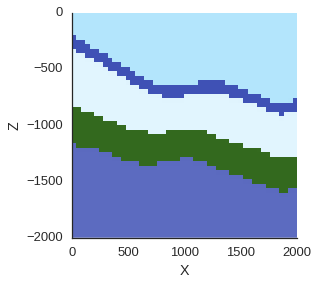

In [10]:
gp.plot_section(geo_data, sol[-1, 0, :], 25, plot_data=True)

Potential field:

/home/miguel/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/miguel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


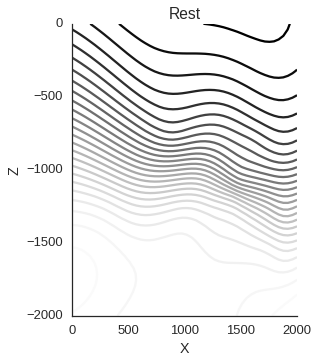

In [21]:
gp.plot_potential_field(geo_data, sol[-1, 1], 25)

In [14]:
ver, sim = gp.get_surfaces(sol[-1, 1], interp_data, original_scale=False)

In [24]:
#interp_data.geo_data_res.interfaces

In [25]:
gp.plot_surfaces_3D(geo_data, ver, sim)

1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0
1450.0 1000.0 -1150.0


In [15]:
sys.path.append("../gempy")

import Visualization 
import importlib
importlib.reload(Visualization)

<module 'Visualization' from '../gempy/Visualization.py'>

In [ ]:
w = Visualization.vtkVisualization(interp_data.geo_data_res, real_time=True )
w.set_surfaces(ver, sim,
               #formations_names_l, formation_numbers_l,
                )
w.interp_data  = interp_data
if True:
    w.set_interfaces()
    w.set_foliations()
w.render_model()

0.5770230769230769 0.5001 0.48086923076923077
0.5770230769230769 0.5001 0.48086923076923077
0.5770230769230769 0.5001 0.48086923076923077
0.5770230769230769 0.5001 0.48086923076923077
[ 0.20522821  0.43856154  0.456121  ]
[ 0.20522821  0.43856154  0.456121  ]
[ 0.20522821  0.43856154  0.456121  ]
[ 0.21548462  0.43856154  0.45418294]
[ 0.21548462  0.45907436  0.46132124]
[ 0.21548462  0.43856154  0.45376262]
[ 0.21548462  0.43856154  0.45376262]
[ 0.21548462  0.43856154  0.45376262]
[ 0.21548462  0.43856154  0.45373339]
[ 0.21548462  0.42830513  0.44860485]
[ 0.21548462  0.45907436  0.46175689]
[ 0.21548462  0.45907436  0.46174287]
[ 0.21548462  0.45907436  0.4616673 ]
[ 0.21548462  0.45907436  0.46165366]
[ 0.20522821  0.41804872  0.44566828]
[ 0.20522821  0.41804872  0.44571897]
[ 0.20522821  0.42055372  0.4475359 ]
[ 0.20522821  0.42049343  0.4475359 ]
[ 0.21548462  0.43856154  0.45553111]
[ 0.21548462  0.43856154  0.4555156 ]
[ 0.21548462  0.4442005   0.45779231]


In [28]:
ver

[array([[ 0.20522821,  0.27670608,  0.76548462],
        [ 0.21548462,  0.28471538,  0.76164953],
        [ 0.21548462,  0.27746809,  0.76548462],
        ..., 
        [ 0.70779231,  0.67445897,  0.74813737],
        [ 0.70779231,  0.67689486,  0.75522821],
        [ 0.70779231,  0.68013614,  0.76548462]]),
 array([[ 0.21042899,  0.24368974,  0.73471538],
        [ 0.21548462,  0.25394615,  0.73064673],
        [ 0.21548462,  0.24510343,  0.73471538],
        ..., 
        [ 0.70779231,  0.70525696,  0.74497179],
        [ 0.70779231,  0.70906552,  0.75522821],
        [ 0.70779231,  0.71263995,  0.76548462]]),
 array([[ 0.21379464,  0.24368974,  0.41676667],
        [ 0.21548462,  0.24422234,  0.41676667],
        [ 0.21548462,  0.24368974,  0.41537432],
        ..., 
        [ 0.70779231,  0.73599744,  0.52782487],
        [ 0.70779231,  0.7382485 ,  0.52958718],
        [ 0.70779231,  0.74625385,  0.53617301]]),
 array([[ 0.20522821,  0.35608629,  0.26292051],
        [ 0.20522821,

In [32]:
a = w.ren_list[0]

In [39]:
a.RemoveActor?